In [2678]:
# pip install folium

In [2679]:
import pulp
from pulp import *

import numpy as np
import pandas as pd

import datetime
import matplotlib.pyplot as plt

In [2680]:
from sklearn.cluster import KMeans

In [2681]:
import folium
import requests

## Load Data

In [2682]:
file_path = 'CSV_Files_Food_Delivery/'

In [2683]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_ordersA = pd.read_csv(file_path + 'part1_ordersA.csv')
df_ordersB = pd.read_csv(file_path + 'part1_ordersB.csv')

In [2684]:
df_regions = pd.read_csv(file_path + 'regions.csv')

In [2685]:
df_distances.head()

origin  \
0  Scarborough (Malvern / Rouge River)   
1  Scarborough (Malvern / Rouge River)   
2  Scarborough (Malvern / Rouge River)   
3  Scarborough (Malvern / Rouge River)   
4  Scarborough (Malvern / Rouge River)   

                                         destination  distance  
0  Scarborough (Rouge Hill / Port Union / Highlan...  3.931478  
1  Scarborough (Guildwood / Morningside / Ellesmere)  4.864191  
2                               Scarborough (Woburn)  4.778347  
3                            Scarborough (Cedarbrae)  6.009861  
4                             Scarborough (Eglinton)  7.876162

In [2686]:
df_ordersA

restaurant                               customer
0  Downtown Toronto (Underground city)  Downtown Toronto (Central Bay Street)

In [2687]:
df_ordersB

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1  Etobicoke Northwest (Clairville / Humberwood /...   
2                                   York (Cedarvale)   
3              Downtown Toronto (Central Bay Street)   
4      Downtown Toronto (Richmond / Adelaide / King)   

                                            customer  
0                Downtown Toronto (Underground city)  
1  Etobicoke (South Steeles / Silverstone / Humbe...  
2  Central Toronto (The Annex / North Midtown / Y...  
3      Downtown Toronto (Richmond / Adelaide / King)  
4    Downtown Toronto (St. James Town / Cabbagetown)

# Part I

## Sets

In [2688]:
starting_location = 'Downtown Toronto (Rosedale)'

In [2689]:
df = df_ordersB

In [2690]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)

In [2691]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [2692]:
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [2693]:
end_locations

['Downtown Toronto (Central Bay Street)',
 'Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)',
 'York (Cedarvale)',
 'Downtown Toronto (Richmond / Adelaide / King)',
 'Downtown Toronto (Underground city)',
 'Etobicoke (South Steeles / Silverstone / Humbergate / Jamestown / Mount Olive / Beaumond Heights / Thistletown / Albion Gardens)',
 'Central Toronto (The Annex / North Midtown / Yorkville)',
 'Downtown Toronto (St. James Town / Cabbagetown)']

In [2694]:
num_steps

[1, 2, 3, 4, 5, 6, 7, 8]

In [2695]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

Restaurant  \
0              Downtown Toronto (Central Bay Street)   
1  Etobicoke Northwest (Clairville / Humberwood /...   
2                                   York (Cedarvale)   
3              Downtown Toronto (Central Bay Street)   
4      Downtown Toronto (Richmond / Adelaide / King)   

                                            Customer  
0                Downtown Toronto (Underground city)  
1  Etobicoke (South Steeles / Silverstone / Humbe...  
2  Central Toronto (The Annex / North Midtown / Y...  
3      Downtown Toronto (Richmond / Adelaide / King)  
4    Downtown Toronto (St. James Town / Cabbagetown)

In [2696]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': np.nan}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': np.nan}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

In [2697]:
travel_df

Start  \
0   Downtown Toronto (Central Bay Street)   
1   Downtown Toronto (Central Bay Street)   
2   Downtown Toronto (Central Bay Street)   
3   Downtown Toronto (Central Bay Street)   
4   Downtown Toronto (Central Bay Street)   
..                                    ...   
67            Downtown Toronto (Rosedale)   
68            Downtown Toronto (Rosedale)   
69            Downtown Toronto (Rosedale)   
70            Downtown Toronto (Rosedale)   
71            Downtown Toronto (Rosedale)   

                                                  End   Distance  Time  
0               Downtown Toronto (Central Bay Street)   0.000000   NaN  
1   Etobicoke Northwest (Clairville / Humberwood /...  17.693277   NaN  
2                                    York (Cedarvale)   5.306327   NaN  
3       Downtown Toronto (Richmond / Adelaide / King)   0.786711   NaN  
4                 Downtown Toronto (Underground city)   0.854155   NaN  
..                                                ...        ...   ...  
67      Downtown Toronto (Richmond / Adelaide / King)   3.772651   NaN  
68                Downtown Toronto (Underground city)   3.799404   NaN  
69  Etobicoke (South Steeles / Silverstone / Humbe...  18.513552   NaN  
70  Central Toronto (The Annex / North Midtown / Y...   2.653323   NaN  
71    Downtown Toronto (St. James Town / Cabbagetown)   1.623918   NaN  

[72 rows x 4 columns]

## Model Setup

In [2698]:
model = LpProblem(name = 'Part1_Model', sense = LpMinimize)

xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)

In [2699]:
obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
             for i in start_locations for j in end_locations for t in num_steps])
model += obj

## Constraints

In [2700]:
def restaurant_customer_match(customer, order_df):
    for index, row in order_df.iterrows():
        if customer == order_df.loc[index, 'Customer']:
            return order_df.loc[index, 'Restaurant']

In [2701]:
# Every location receives order once
for j in end_locations: 
    model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

In [2702]:
# Convervation of flow
for t in num_steps[:-1]:
    for j in end_locations:
        model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

In [2703]:
# First node has an outflow of 1, others 0
model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

for i in start_locations[:-1]:
    model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

In [2704]:
# Visit restaurant before customer
for t in num_steps: 
    for j in end_locations: 
        if j in customers: 
            model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                        for i in start_locations \
                                                                                        for t_ in num_steps[:t]])

## Solve

In [2705]:
# Solve the model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [2706]:
# Total Distance
total_distance = pulp.value(model.objective)
print("Total Distance: " , total_distance)

Total Distance:  33.875942274546034


In [2707]:
# Print the results
path=[]
for t in num_steps:
    print(f'step:{t}\n')
    for i in start_locations:
         for j in end_locations:
                if (xVar[(i,j,t)].varValue == 1) :
                    print(f"TRAVEL FROM {i}  TO {j}")
                    
                    if i not in path:
                        path.append(i)
                    if j not in path:
                        path.append(j)

step:1

TRAVEL FROM Downtown Toronto (Rosedale)  TO Downtown Toronto (Central Bay Street)
step:2

TRAVEL FROM Downtown Toronto (Central Bay Street)  TO Downtown Toronto (Richmond / Adelaide / King)
step:3

TRAVEL FROM Downtown Toronto (Richmond / Adelaide / King)  TO Downtown Toronto (Underground city)
step:4

TRAVEL FROM Downtown Toronto (Underground city)  TO Downtown Toronto (St. James Town / Cabbagetown)
step:5

TRAVEL FROM Downtown Toronto (St. James Town / Cabbagetown)  TO York (Cedarvale)
step:6

TRAVEL FROM York (Cedarvale)  TO Central Toronto (The Annex / North Midtown / Yorkville)
step:7

TRAVEL FROM Central Toronto (The Annex / North Midtown / Yorkville)  TO Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)
step:8

TRAVEL FROM Etobicoke Northwest (Clairville / Humberwood / Woodbine Downs / West Humber / Kipling Heights / Rexdale / Elms / Tandridge / Old Rexdale)  TO Etobicoke (South Steel

In [2708]:
route_=[]
for index,r in enumerate(path):
    lat=df_regions.loc[df_regions['name'] == r]['latitude'].values[0]
    log=df_regions.loc[df_regions['name'] == r]['longitude'].values[0]
    route_.append((lat,log))

In [2709]:
# Load the GeoJSON data for Toronto from a URL
url = 'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson'
response = requests.get(url)
toronto_geojson = response.json()

# Create a map of Toronto
m = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

# Add the GeoJSON data to the map as a layer
folium.GeoJson(toronto_geojson).add_to(m)

# Define the route as a list of (lat, lon) coordinates
route = route_

# Add the route to the map as a PolyLine
folium.PolyLine(route, color='red').add_to(m)

# Add numbered markers for each location to the map
for i, location in enumerate(route):
    folium.Marker(location=location, icon=folium.Icon(color='blue'), 
                  popup=str(i+1)).add_to(m)

# Display the map
m


# Part II

## Load Data

In [2710]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_ordersA = pd.read_csv(file_path + 'part2_ordersA.csv')
df_ordersB = pd.read_csv(file_path + 'part2_ordersB.csv')

In [2711]:
df_distances.head()

origin  \
0  Scarborough (Malvern / Rouge River)   
1  Scarborough (Malvern / Rouge River)   
2  Scarborough (Malvern / Rouge River)   
3  Scarborough (Malvern / Rouge River)   
4  Scarborough (Malvern / Rouge River)   

                                         destination  distance  
0  Scarborough (Rouge Hill / Port Union / Highlan...  3.931478  
1  Scarborough (Guildwood / Morningside / Ellesmere)  4.864191  
2                               Scarborough (Woburn)  4.778347  
3                            Scarborough (Cedarbrae)  6.009861  
4                             Scarborough (Eglinton)  7.876162

In [2712]:
df_ordersA

restaurant               customer  \
0  Scarborough (Kennedy Park / Ionview / East Bir...   Scarborough (Woburn)   
1               Central Toronto (North Toronto West)  Etobicoke (Westmount)   

  estimated availability  
0     2022-04-02 7:27 PM  
1     2022-04-02 8:30 PM

In [2713]:
df_ordersB

restaurant  \
0                       Etobicoke (Islington Avenue)   
1           North York (Sweeney Park / Wigmore Park)   
2  Scarborough (The Golden Mile / Clairlea / Oakr...   
3                              Etobicoke (Westmount)   

                                            customer estimated availability  
0  Downtown Toronto Stn A PO Boxes 25 The Esplana...     2022-04-02 5:17 PM  
1  Downtown Toronto (University of Toronto / Harb...     2022-04-02 5:49 PM  
2                        Downtown Toronto (Rosedale)     2022-04-02 6:17 PM  
3  Etobicoke (West Deane Park / Princess Gardens ...     2022-04-02 5:53 PM

## Data Preparation

In [2714]:
# Route A or B
route = 'B'

In [2715]:
starting_location = 'Downtown Toronto (Rosedale)'
average_velocity = 40 # Km/Hr
average_wait = 5 # Mins

# Convert to Km/Min
velocity_min = average_velocity / 60

In [2716]:
# Route variables
W = 120
test_W = range(0, 120, 5)

if route == 'A':
    print('Route A')
    df = df_ordersA
    start_time = pd.to_datetime('2022-04-02 19:00:00')
else:
    print('Route B')
    df = df_ordersB
    start_time = pd.to_datetime('2022-04-02 17:00:00')

Route B


In [2717]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)


In [2718]:
order_locations = list(df['restaurant']) + list(df['customer'])
order_locations

['Etobicoke (Islington Avenue)',
 'North York (Sweeney Park / Wigmore Park)',
 'Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)',
 'Etobicoke (Westmount)',
 'Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)',
 'Downtown Toronto (University of Toronto / Harbord)',
 'Downtown Toronto (Rosedale)',
 'Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)']

In [2719]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [2720]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [2721]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

Restaurant  \
0                       Etobicoke (Islington Avenue)   
1           North York (Sweeney Park / Wigmore Park)   
2  Scarborough (The Golden Mile / Clairlea / Oakr...   
3                              Etobicoke (Westmount)   

                                            Customer  
0  Downtown Toronto Stn A PO Boxes 25 The Esplana...  
1  Downtown Toronto (University of Toronto / Harb...  
2                        Downtown Toronto (Rosedale)  
3  Etobicoke (West Deane Park / Princess Gardens ...

In [2722]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

Start  \
0  Etobicoke (Islington Avenue)   
1  Etobicoke (Islington Avenue)   
2  Etobicoke (Islington Avenue)   
3  Etobicoke (Islington Avenue)   
4  Etobicoke (Islington Avenue)   

                                                 End   Distance       Time  
0                       Etobicoke (Islington Avenue)   0.000000   0.000000  
1           North York (Sweeney Park / Wigmore Park)  18.464774  27.697161  
2  Scarborough (The Golden Mile / Clairlea / Oakr...  20.266821  30.400231  
3                              Etobicoke (Westmount)   3.208285   4.812428  
4  Downtown Toronto Stn A PO Boxes 25 The Esplana...  12.284849  18.427273

In [2723]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [2724]:
df

restaurant  \
0                       Etobicoke (Islington Avenue)   
1           North York (Sweeney Park / Wigmore Park)   
2  Scarborough (The Golden Mile / Clairlea / Oakr...   
3                              Etobicoke (Westmount)   

                                            customer estimated availability  \
0  Downtown Toronto Stn A PO Boxes 25 The Esplana...    2022-04-02 17:17:00   
1  Downtown Toronto (University of Toronto / Harb...    2022-04-02 17:49:00   
2                        Downtown Toronto (Rosedale)    2022-04-02 18:17:00   
3  Etobicoke (West Deane Park / Princess Gardens ...    2022-04-02 17:53:00   

   Converted Availability  
0                     0.0  
1                    32.0  
2                    60.0  
3                    36.0

## Model

In [2725]:
model = LpProblem(name = 'Part2_Model', sense = LpMinimize)

xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)
# zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
dVar = LpVariable.dict('d', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
aVar = LpVariable.dict('a', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
wVar = LpVariable.dict('w', (start_locations, num_steps), lowBound = 0.0, cat = LpContinuous)
# vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

In [2726]:
obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
             for i in start_locations for j in end_locations for t in num_steps])
model += obj

In [2727]:
model += dVar[(0)] <= 0

In [2728]:
def travel_time_lookup(i, j, travel_df):
    return travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [2729]:
# # Step time calculation
# for t in num_steps:
#     model += dVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
#                                                for i in start_locations for j in restaurants]) + \
#                           lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
#                                  for i in start_locations for j in customers])

In [2730]:
# # Assign time to each travel in vVar
# for i in start_locations:
#     for j in end_locations:
#         model += vVar[(i,j)] == travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [2731]:
# # Driver arrives after the food is ready
# for t in num_steps:
#     for i in start_locations:
#         for j in range(0, int(len(order_locations)/2)):
#             model += dVar[(t)] >= df.loc[j, 'Converted Availability'] * xVar[(i,df.loc[j, 'restaurant'],t)]

In [2732]:
# Step time calculation
for t in num_steps:
    model += aVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
                                               for i in start_locations for j in restaurants]) + \
                          lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
                                 for i in start_locations for j in customers])
    model += aVar[(t)] <= dVar[(t)]

In [2733]:
# Driver leaves after the food is ready
for t in num_steps:
    for i in start_locations:
        for j in restaurants:
            model += dVar[(t)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t)]

In [2734]:
# Visit restaurant before customer
for t in num_steps: 
    for j in end_locations: 
        if j in customers: 
            model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                        for i in start_locations \
                                                                                        for t_ in num_steps[:t]])

In [2735]:
for idx, row in df.iterrows():
    rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
    for t in num_steps:
        model += wVar[(cus, t)] <= 10000000 * lpSum(xVar[(i, cus, t)] for i in start_locations if i != cus)
        
        model += wVar[(cus, t)] <= aVar[t] - time + 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))
        model += wVar[(cus, t)] >= aVar[t] - time - 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))

In [2736]:
model += W >= lpSum(wVar[(c,t)] for c in customers for t in num_steps)/len(df)

In [2737]:
# Every location receives order once
for j in end_locations: 
    model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

In [2738]:
# Convervation of flow
for t in num_steps[:-1]:
    for j in end_locations:
        model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

In [2739]:
# First node has an outflow of 1, others 0
model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

for i in start_locations[:-1]:
    model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

## Solve

In [2740]:
# Solve the model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [2741]:
# Total Distance
total_distance = pulp.value(model.objective)
print("Total Distance: " , total_distance)

Total Distance:  51.40200682468171


In [2742]:
# Print the results
path=[]
for t in num_steps:
    print(f'step:{t}\n')
    for i in start_locations:
         for j in end_locations:
                if (xVar[(i,j,t)].varValue == 1) :
                    print(f"TRAVEL FROM {i}  TO {j}")
                    
                    if i not in path:
                        path.append(i)
                    if j not in path:
                        path.append(j)

step:1

TRAVEL FROM Downtown Toronto (Rosedale)  TO North York (Sweeney Park / Wigmore Park)
step:2

TRAVEL FROM North York (Sweeney Park / Wigmore Park)  TO Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
step:3

TRAVEL FROM Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)  TO Downtown Toronto (Rosedale)
step:4

TRAVEL FROM Downtown Toronto (Rosedale)  TO Etobicoke (Westmount)
step:5

TRAVEL FROM Etobicoke (Westmount)  TO Etobicoke (Islington Avenue)
step:6

TRAVEL FROM Etobicoke (Islington Avenue)  TO Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)
step:7

TRAVEL FROM Etobicoke (West Deane Park / Princess Gardens / Martin Grove / Islington / Cloverdale)  TO Downtown Toronto (University of Toronto / Harbord)
step:8

TRAVEL FROM Downtown Toronto (University of Toronto / Harbord)  TO Downtown Toronto Stn A PO Boxes 25 The Esplanade (Enclave of M5E)


In [2743]:
# Print Results
for t in num_steps: 
    print('Stop number: ' + str(t))
    print('Travel time(mins): ' + str(dVar[t].varValue))
    
    for i in start_locations: 
        for j in end_locations: 
            
            if xVar[(i,j,t)].varValue > 0.0:
                print('\tLeft from location: ' + str(i))
                print('\tArrived at location: ' + str(j))
                print('\tWait time: ' + str(wVar[(j,t)].varValue))
#                 print('\tSum of wait times: ' + str(zVar[t].varValue))
total_wait_time = sum([wVar[(j,t)].varValue for j in end_locations for t in num_steps if wVar[(j,t)].varValue != None])
print('Total wait: ' + str(total_wait_time))
wait_time = str(total_wait_time / len(customers))              
print('Average wait: ' + wait_time)

Stop number: 1
Travel time(mins): 32.0
	Left from location: Downtown Toronto (Rosedale)
	Arrived at location: North York (Sweeney Park / Wigmore Park)
	Wait time: None
Stop number: 2
Travel time(mins): 60.0
	Left from location: North York (Sweeney Park / Wigmore Park)
	Arrived at location: Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
	Wait time: None
Stop number: 3
Travel time(mins): 76.773828
	Left from location: Scarborough (The Golden Mile / Clairlea / Oakridge / Birchmount Park East)
	Arrived at location: Downtown Toronto (Rosedale)
	Wait time: 16.773828
Stop number: 4
Travel time(mins): 96.094155
	Left from location: Downtown Toronto (Rosedale)
	Arrived at location: Etobicoke (Westmount)
	Wait time: None
Stop number: 5
Travel time(mins): 100.90658
	Left from location: Etobicoke (Westmount)
	Arrived at location: Etobicoke (Islington Avenue)
	Wait time: None
Stop number: 6
Travel time(mins): 109.76646
	Left from location: Etobicoke (Islington Avenue)
	A

In [2744]:
route_=[]
for index,r in enumerate(path):
    lat=df_regions.loc[df_regions['name'] == r]['latitude'].values[0]
    log=df_regions.loc[df_regions['name'] == r]['longitude'].values[0]
    route_.append((lat,log))

In [2745]:
# Load the GeoJSON data for Toronto from a URL
url = 'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson'
response = requests.get(url)
toronto_geojson = response.json()

# Create a map of Toronto
m = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

# Add the GeoJSON data to the map as a layer
folium.GeoJson(toronto_geojson).add_to(m)

# Define the route as a list of (lat, lon) coordinates
route = route_

# Add the route to the map as a PolyLine
folium.PolyLine(route, color='red').add_to(m)

# Add numbered markers for each location to the map
for i, location in enumerate(route):
    folium.Marker(location=location, icon=folium.Icon(color='blue'), 
                  popup=str(i+1)).add_to(m)

# Display the map
m


## Sensitivity

### Data Preparation

In [2746]:
# Route A or B
route = 'B'

In [2747]:
starting_location = 'Downtown Toronto (Rosedale)'
average_velocity = 40 # Km/Hr
average_wait = 5 # Mins

# Convert to Km/Min
velocity_min = average_velocity / 60

In [2748]:
# Route variables
test_W = range(0, 120, 5)

if route == 'A':
    print('Route A')
    df = df_ordersA
else:
    print('Route B')
    df = df_ordersB

Route B


In [2749]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

if starting_location in start_locations:
    start_locations.remove(starting_location)
    start_locations.append(starting_location)
else:
    start_locations.append(starting_location)


In [2750]:
order_locations = list(df['restaurant']) + list(df['customer'])

In [2751]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [2752]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [2753]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

Restaurant  \
0                       Etobicoke (Islington Avenue)   
1           North York (Sweeney Park / Wigmore Park)   
2  Scarborough (The Golden Mile / Clairlea / Oakr...   
3                              Etobicoke (Westmount)   

                                            Customer  
0  Downtown Toronto Stn A PO Boxes 25 The Esplana...  
1  Downtown Toronto (University of Toronto / Harb...  
2                        Downtown Toronto (Rosedale)  
3  Etobicoke (West Deane Park / Princess Gardens ...

In [2754]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

Start  \
0  Etobicoke (Islington Avenue)   
1  Etobicoke (Islington Avenue)   
2  Etobicoke (Islington Avenue)   
3  Etobicoke (Islington Avenue)   
4  Etobicoke (Islington Avenue)   

                                                 End   Distance       Time  
0                       Etobicoke (Islington Avenue)   0.000000   0.000000  
1           North York (Sweeney Park / Wigmore Park)  18.464774  27.697161  
2  Scarborough (The Golden Mile / Clairlea / Oakr...  20.266821  30.400231  
3                              Etobicoke (Westmount)   3.208285   4.812428  
4  Downtown Toronto Stn A PO Boxes 25 The Esplana...  12.284849  18.427273

In [2755]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [2756]:
df

restaurant  \
0                       Etobicoke (Islington Avenue)   
1           North York (Sweeney Park / Wigmore Park)   
2  Scarborough (The Golden Mile / Clairlea / Oakr...   
3                              Etobicoke (Westmount)   

                                            customer estimated availability  \
0  Downtown Toronto Stn A PO Boxes 25 The Esplana...    2022-04-02 17:17:00   
1  Downtown Toronto (University of Toronto / Harb...    2022-04-02 17:49:00   
2                        Downtown Toronto (Rosedale)    2022-04-02 18:17:00   
3  Etobicoke (West Deane Park / Princess Gardens ...    2022-04-02 17:53:00   

   Converted Availability  
0                     0.0  
1                    32.0  
2                    60.0  
3                    36.0

In [2757]:
def one_driver_within_W(W):
    
    print("W:", W)

    model = LpProblem(name = 'Part2_Model', sense = LpMinimize)

    xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)
    # zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
    dVar = LpVariable.dict('d', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
    aVar = LpVariable.dict('a', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
    wVar = LpVariable.dict('w', (start_locations, num_steps), lowBound = 0.0, cat = LpContinuous)
#     vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

    obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
                 for i in start_locations for j in end_locations for t in num_steps])
    model += obj

    model += dVar[(0)] <= 0

    def travel_time_lookup(i, j, travel_df):
        return travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

    # Step time calculation
    for t in num_steps:
        model += aVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
                                                   for i in start_locations for j in restaurants]) + \
                              lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
                                     for i in start_locations for j in customers])
        model += aVar[(t)] <= dVar[(t)]

    # Driver leaves after the food is ready
    for t in num_steps:
        for i in start_locations:
            for j in restaurants:
                model += dVar[(t)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t)]

    # Visit restaurant before customer
    for t in num_steps: 
        for j in end_locations: 
            if j in customers: 
                model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                            for i in start_locations \
                                                                                            for t_ in num_steps[:t]])

    for idx, row in df.iterrows():
        rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
        for t in num_steps:
            model += wVar[(cus, t)] <= 10000000 * lpSum(xVar[(i, cus, t)] for i in start_locations if i != cus)

            model += wVar[(cus, t)] <= aVar[t] - time + 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))
            model += wVar[(cus, t)] >= aVar[t] - time - 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))

    model += W >= lpSum(wVar[(c,t)] for c in customers for t in num_steps)/len(df)

    # Every location receives order once
    for j in end_locations: 
        model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

    # Convervation of flow
    for t in num_steps[:-1]:
        for j in end_locations:
            model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

    # First node has an outflow of 1, others 0
    model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

    for i in start_locations[:-1]:
        model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

    # Solve the model
    model.solve()
    print("Status:", LpStatus[model.status])
    model_status = LpStatus[model.status]
    
    if LpStatus[model.status] == 'Optimal':
    
        total_distance = pulp.value(model.objective)
        print("Total Distance: " , total_distance)

        total_wait_time = sum([wVar[(j,t)].varValue for j in end_locations for t in num_steps if wVar[(j,t)].varValue != None])
        print('Total wait: ' + str(total_wait_time))
        
        avg_wait_time = total_wait_time/len(customers)
        print('Average wait: ' + str(avg_wait_time))
        
    else:
        total_distance = 0
        total_wait_time = 0
        avg_wait_time = 0
    
    print('=======================================')
        
    return {'w': W,
           'model_status': model_status,
           'total_distance': total_distance,
           'total_wait_time': total_wait_time,
            'avg_wait_time': avg_wait_time
           }

W: 0
Status: Infeasible
W: 5
Status: Infeasible
W: 10
Status: Infeasible
W: 15
Status: Infeasible
W: 20
Status: Infeasible
W: 25
Status: Infeasible
W: 30
Status: Infeasible
W: 35
Status: Infeasible
W: 40
Status: Infeasible
W: 45
Status: Optimal
Total Distance:  65.90619703138421
Total wait: 174.551761
Average wait: 43.63794025
W: 50
Status: Optimal
Total Distance:  65.00241802135857
Total wait: 183.47445299999998
Average wait: 45.868613249999996
W: 55
Status: Optimal
Total Distance:  65.00241802135857
Total wait: 183.47445299999998
Average wait: 45.868613249999996
W: 60
Status: Optimal
Total Distance:  56.208047427933266
Total wait: 229.70876099999998
Average wait: 57.427190249999995
W: 65
Status: Optimal
Total Distance:  55.62850430505601
Total wait: 253.58389
Average wait: 63.3959725
W: 70
Status: Optimal
Total Distance:  55.62850430505601
Total wait: 253.58389
Average wait: 63.3959725
W: 75
Status: Optimal
Total Distance:  51.74082398875608
Total wait: 294.89335400000004
Average wai

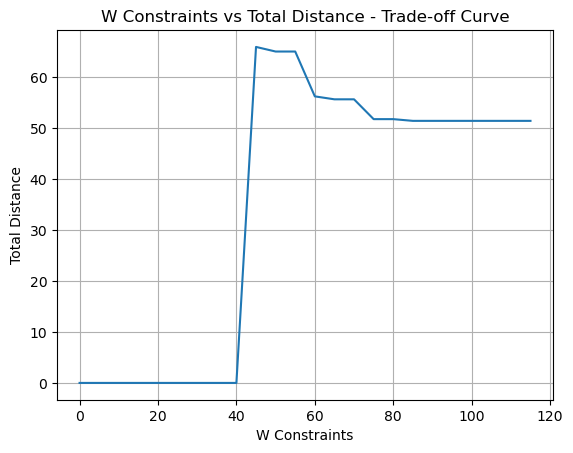

In [2758]:
test_W = range(0, 120, 5)
result_dict = {}
total_distance_list = []
avg_wait_time_list = []

for w in test_W:
    result_dict[w] = one_driver_within_W(w)
    total_distance_list.append(result_dict[w]['total_distance'])
    avg_wait_time_list.append(result_dict[w]['avg_wait_time'])
    
# Plot the optimal W Value
plt.plot(test_W, total_distance_list)
plt.xlabel('W Constraints')
plt.ylabel('Total Distance')
plt.title('W Constraints vs Total Distance - Trade-off Curve')
plt.grid(True)

# Part III

## Load Data

In [2759]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_orders = pd.read_csv(file_path + 'part3_small.csv')
df_drivers = pd.read_csv(file_path + 'part3_drivers.csv')

In [2760]:
df_distances.head()

origin  \
0  Scarborough (Malvern / Rouge River)   
1  Scarborough (Malvern / Rouge River)   
2  Scarborough (Malvern / Rouge River)   
3  Scarborough (Malvern / Rouge River)   
4  Scarborough (Malvern / Rouge River)   

                                         destination  distance  
0  Scarborough (Rouge Hill / Port Union / Highlan...  3.931478  
1  Scarborough (Guildwood / Morningside / Ellesmere)  4.864191  
2                               Scarborough (Woburn)  4.778347  
3                            Scarborough (Cedarbrae)  6.009861  
4                             Scarborough (Eglinton)  7.876162

In [2761]:
df_orders

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM  
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM  
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM  
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM  
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM

In [2762]:
df_drivers

start region  velocity
0  Downtown Toronto (Richmond / Adelaide / King)        40
1              Downtown Toronto (St. James Park)        35
2        Downtown Toronto (Church and Wellesley)        32

## Data Preparation

In [2763]:
# Route variables
W = 10000
df = df_orders.copy()

In [2764]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

In [2765]:
df_drivers

start region  velocity
0  Downtown Toronto (Richmond / Adelaide / King)        40
1              Downtown Toronto (St. James Park)        35
2        Downtown Toronto (Church and Wellesley)        32

In [2766]:
num_drivers = list(range(1,len(df_drivers)+1))
num_drivers

[1, 2, 3]

In [2767]:
driver_origins = df_drivers['start region'].to_list()
driver_origins

['Downtown Toronto (Richmond / Adelaide / King)',
 'Downtown Toronto (St. James Park)',
 'Downtown Toronto (Church and Wellesley)']

In [2768]:
for starting_location in driver_origins:
    
    if starting_location in start_locations:
        start_locations.remove(starting_location)
        start_locations.append(starting_location)
    else:
        start_locations.append(starting_location)


In [2769]:
order_locations = list(df['restaurant']) + list(df['customer'])
order_locations

['Downtown Toronto (Central Bay Street)',
 'Downtown Toronto (Christie)',
 'Downtown Toronto (Ryerson)',
 'Downtown Toronto (St. James Park)',
 'Downtown Toronto (Kensington Market / Chinatown / Grange Park)',
 'North York (Armour Heights / Wilson Heights / Downsview North)',
 'West Toronto (Brockton / Parkdale Village / Exhibition Place)',
 'York (Fairbank / Oakwood)',
 'East Toronto (The Beaches)',
 'Downtown Toronto (Central Bay Street)']

In [2770]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [2771]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [2772]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

Restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            Customer  
0  North York (Armour Heights / Wilson Heights / ...  
1  West Toronto (Brockton / Parkdale Village / Ex...  
2                          York (Fairbank / Oakwood)  
3                         East Toronto (The Beaches)  
4              Downtown Toronto (Central Bay Street)

In [2773]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

Start  \
0  Downtown Toronto (Central Bay Street)   
1  Downtown Toronto (Central Bay Street)   
2  Downtown Toronto (Central Bay Street)   
3  Downtown Toronto (Central Bay Street)   
4  Downtown Toronto (Central Bay Street)   

                                                 End  Distance      Time  
0              Downtown Toronto (Central Bay Street)  0.000000  0.000000  
1                        Downtown Toronto (Christie)  3.074525  4.611787  
2                         Downtown Toronto (Ryerson)  0.625806  0.938710  
3                  Downtown Toronto (St. James Park)  1.010776  1.516165  
4  Downtown Toronto (Kensington Market / Chinatow...  0.983161  1.474741

In [2774]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [2775]:
df

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  \
0  North York (Armour Heights / Wilson Heights / ...    2022-04-02 17:17:00   
1  West Toronto (Brockton / Parkdale Village / Ex...    2022-04-02 17:49:00   
2                          York (Fairbank / Oakwood)    2022-04-02 18:17:00   
3                         East Toronto (The Beaches)    2022-04-02 17:53:00   
4              Downtown Toronto (Central Bay Street)    2022-04-02 17:24:00   

   Converted Availability  
0                     0.0  
1                    32.0  
2                    60.0  
3                    36.0  
4                     7.0

## Model

In [2776]:
model = LpProblem(name = 'Part3_Model', sense = LpMinimize)

xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps, num_drivers), cat = LpBinary)
# zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
dVar = LpVariable.dict('d', ([0] + num_steps, num_drivers), lowBound = -9999.0, cat = LpContinuous)
aVar = LpVariable.dict('a', ([0] + num_steps, num_drivers), lowBound = -9999.0, cat = LpContinuous)
wVar = LpVariable.dict('w', (start_locations, num_steps, num_drivers), lowBound = 0.0, cat = LpContinuous)
# vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

In [2777]:
obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t,p)] \
             for i in start_locations for j in end_locations for t in num_steps for p in num_drivers])
model += obj

In [2778]:
for p in num_drivers:
    model += dVar[(0, p)] <= 0

In [2779]:
def travel_time_driver_lookup(i, j, p, travel_df, df_drivers):
    d_temp = float(travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0])
    v_temp = float(df_drivers.loc[p-1, 'velocity'])
    return d_temp/v_temp*60

In [2780]:
# # Step time calculation
# for t in num_steps:
#     model += dVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
#                                                for i in start_locations for j in restaurants]) + \
#                           lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
#                                  for i in start_locations for j in customers])

In [2781]:
# # Assign time to each travel in vVar
# for i in start_locations:
#     for j in end_locations:
#         model += vVar[(i,j)] == travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

In [2782]:
# # Driver arrives after the food is ready
# for t in num_steps:
#     for i in start_locations:
#         for j in range(0, int(len(order_locations)/2)):
#             model += dVar[(t)] >= df.loc[j, 'Converted Availability'] * xVar[(i,df.loc[j, 'restaurant'],t)]

In [2783]:
# Step time calculation
for p in num_drivers:
    for t in num_steps:
        model += aVar[(t,p)] == dVar[(t-1,p)] + lpSum([travel_time_driver_lookup(i, j, p, travel_df, df_drivers) * xVar[(i,j,t,p)] \
                                                   for i in start_locations for j in restaurants]) + \
                              lpSum([(travel_time_driver_lookup(i, j, p, travel_df, df_drivers) + 5) * xVar[(i,j,t,p)] \
                                     for i in start_locations for j in customers])
        model += aVar[(t,p)] <= dVar[(t,p)]

In [2784]:
# Driver leaves after the food is ready
for p in num_drivers:
    for t in num_steps:
        for i in start_locations:
            for j in restaurants:
                model += dVar[(t,p)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t,p)]

In [2785]:
# Visit restaurant before customer
for p in num_drivers:
    for t in num_steps: 
        for j in end_locations: 
            if j in customers: 
                model += pulp.lpSum( [xVar[i,j,t,p] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_,p] \
                                                                                            for i in start_locations \
                                                                                            for t_ in num_steps[:t]])

In [2786]:
# for p in num_drivers:
#     for idx, row in df.iterrows():
#         rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
#         for t in num_steps:
#             model += wVar[(cus,t,p)] <= 10000000 * lpSum(xVar[(i,cus,t,p)] for i in start_locations if i != cus)

#             model += wVar[(cus,t,p)] <= aVar[t,p] - time + 10000000 * (1 - lpSum(xVar[(i,cus,t,p)] for i in start_locations if i !=cus))
#             model += wVar[(cus,t,p)] >= aVar[t,p] - time - 10000000 * (1 - lpSum(xVar[(i,cus,t,p)] for i in start_locations if i !=cus))

In [2787]:
for p in num_drivers:
    for idx, row in df.iterrows():
        rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
        for t in num_steps:
            model += wVar[(cus,t,p)] <= 10000000 * lpSum(xVar[(i,cus,t,p)] for i in start_locations)

            model += wVar[(cus,t,p)] <= aVar[t,p] - time + 10000000 * (1 - lpSum(xVar[(i,cus,t,p)] for i in start_locations))
            model += wVar[(cus,t,p)] >= aVar[t,p] - time - 10000000 * (1 - lpSum(xVar[(i,cus,t,p)] for i in start_locations))

In [2788]:
model += W >= lpSum(wVar[(c,t,p)] for c in customers for t in num_steps for p in num_drivers)/len(df)

In [2789]:
# Every location receives order once
for j in end_locations: 
    model += lpSum([xVar[(i,j,t,p)] for i in start_locations for t in num_steps for p in num_drivers]) == 1

In [2790]:
for p in num_drivers:
    for t in num_steps:
        model += lpSum([xVar[(i,j,t,p)] for i in start_locations for j in end_locations]) <= 1

In [2791]:
# Convervation of flow
for p in num_drivers:
    for t in num_steps[:-1]:
        for j in end_locations:
            if t == 1:
                model += (lpSum([xVar[(i,j,t,p)] for i in start_locations]) >= lpSum([xVar[(j,k,t+1,p)] for k in end_locations]))
            else:
                model += (lpSum([xVar[(i,j,t,p)] for i in end_locations]) >= lpSum([xVar[(j,k,t+1,p)] for k in end_locations]))
            
#             model += (lpSum([xVar[(i,j,t,p)] for i in start_locations])) >= lpSum([xVar[(i,k,t+1,p)] for i in start_locations for k in end_locations])
#             model += 1000000 * (1 - lpSum([xVar[(i,j,t,p)] for i in start_locations]))+1 >= (lpSum([xVar[(i,k,t+1,p)] for i in start_locations for k in end_locations]))
#             model += (lpSum([xVar[(i,j,t,p)] for i in start_locations])) <=1
#             model += (lpSum([xVar[(m,k,t+1,p)] for k in end_locations for m in start_locations if m!= j])) == 0

            model += (lpSum([xVar[(m,k,t+1,p)] for k in end_locations for m in start_locations if m!= j])) <= 1000000 * (1 - lpSum([xVar[(i,j,t,p)] for i in start_locations]))
            model += (lpSum([xVar[(m,k,t+1,p)] for k in end_locations for m in start_locations if m!= j])) >= - 1000000 * (1 - lpSum([xVar[(i,j,t,p)] for i in start_locations]))
                                                                                                                         

In [2792]:
# # First node has an outflow of 1, others 0
# model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

# for i in start_locations[:-1]:
#     model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

In [2793]:
# All drivers must have orders
model += (lpSum([xVar[(i,j,1,p)] for i in start_locations for j in end_locations for p in num_drivers])) == len(num_drivers)  

In [2794]:
# Drivers must start from different origins
for i in start_locations[-len(num_drivers):]:
    model += (lpSum([xVar[(i,j,1,p)] for j in end_locations for p in num_drivers])) == 1

In [2795]:
# Each driver can only go to 1 location from their origins in step 1
for p in num_drivers:
    model += (lpSum([xVar[(driver_origins[p-1],j,1,p)] for j in end_locations])) <= 1
  

In [2796]:
for p in num_drivers:
    for i in start_locations[:-len(num_drivers)]:
        model += (lpSum([xVar[(i,j,1,p)] for j in end_locations])) == 0

## Solve

In [2797]:
# Solve the model
model.solve()
print("Status:", LpStatus[model.status])

Status: Optimal


In [2798]:
# Total Distance
total_distance = pulp.value(model.objective)
print("Total Distance: " , total_distance)

Total Distance:  30.544085866191324


In [2799]:
# Print the results
path=[]
for p in num_drivers:
    print('Driver number: ' + str(p))
    for t in num_steps:
        print(f'step:{t}\n')
        for i in start_locations:
             for j in end_locations:
                    if (xVar[(i,j,t,p)].varValue == 1) :
                        print(f"TRAVEL FROM {i}  TO {j}")

                        if i not in path:
                            path.append(i)
                        if j not in path:
                            path.append(j)

Driver number: 1
step:1

TRAVEL FROM Downtown Toronto (Richmond / Adelaide / King)  TO Downtown Toronto (Kensington Market / Chinatown / Grange Park)
step:2

TRAVEL FROM Downtown Toronto (Kensington Market / Chinatown / Grange Park)  TO Downtown Toronto (Central Bay Street)
step:3

TRAVEL FROM Downtown Toronto (Central Bay Street)  TO Downtown Toronto (Ryerson)
step:4

TRAVEL FROM Downtown Toronto (Ryerson)  TO York (Fairbank / Oakwood)
step:5

TRAVEL FROM York (Fairbank / Oakwood)  TO North York (Armour Heights / Wilson Heights / Downsview North)
step:6

step:7

step:8

step:9

Driver number: 2
step:1

TRAVEL FROM Downtown Toronto (Church and Wellesley)  TO Downtown Toronto (Christie)
step:2

TRAVEL FROM Downtown Toronto (Christie)  TO West Toronto (Brockton / Parkdale Village / Exhibition Place)
step:3

step:4

step:5

step:6

step:7

step:8

step:9

Driver number: 3
step:1

TRAVEL FROM Downtown Toronto (St. James Park)  TO Downtown Toronto (St. James Park)
step:2

TRAVEL FROM Downto

In [2800]:
route_=[]
for index,r in enumerate(path):
    lat=df_regions.loc[df_regions['name'] == r]['latitude'].values[0]
    log=df_regions.loc[df_regions['name'] == r]['longitude'].values[0]
    route_.append((lat,log))

In [2802]:
import matplotlib.colors as mcolors

In [2804]:
# Load the GeoJSON data for Toronto from a URL
url = 'https://raw.githubusercontent.com/jasonicarter/toronto-geojson/master/toronto_crs84.geojson'
response = requests.get(url)
toronto_geojson = response.json()

# Create a map of Toronto
m = folium.Map(location=[43.6532, -79.3832], zoom_start=12)

# Add the GeoJSON data to the map as a layer
folium.GeoJson(toronto_geojson).add_to(m)

# Get a list of colors for the different routes
colors = list(mcolors.TABLEAU_COLORS.values())

# Iterate over the drivers
for driver_num, p in enumerate(num_drivers):
    path = []
    for t in num_steps:
        for i in start_locations:
            for j in end_locations:
                if xVar[(i, j, t, p)].varValue == 1:
                    if i not in path:
                        path.append(i)
                    if j not in path:
                        path.append(j)

    route_ = []
    for index, r in enumerate(path):
        lat = df_regions.loc[df_regions['name'] == r]['latitude'].values[0]
        log = df_regions.loc[df_regions['name'] == r]['longitude'].values[0]
        route_.append((lat, log))

    # Add the route to the map as a PolyLine
    folium.PolyLine(route_, color=colors[driver_num % len(colors)]).add_to(m)

    # Add numbered markers for each location to the map
    for i, location in enumerate(route_):
        folium.Marker(location=location, icon=folium.Icon(color=colors[driver_num % len(colors)]),
                      popup=f"Driver {p}: {i + 1}").add_to(m)

# Display the map
m

C:\Users\ddjgy\AppData\Local\Temp\ipykernel_25628\760085518.py:38: UserWarning: color argument of Icon should be one of: {'white', 'lightred', 'darkgreen', 'beige', 'green', 'darkblue', 'pink', 'darkred', 'black', 'gray', 'lightgray', 'lightblue', 'purple', 'red', 'blue', 'darkpurple', 'lightgreen', 'orange', 'cadetblue'}.
  folium.Marker(location=location, icon=folium.Icon(color=colors[driver_num % len(colors)]),


In [2805]:
# Print Results
for p in num_drivers:
    print('Driver number: ' + str(p))
    for t in num_steps: 
        print('\tStop number: ' + str(t))
        print('\tTravel time(mins): ' + str(dVar[t,p].varValue))

        for i in start_locations: 
            for j in end_locations: 

                if xVar[(i,j,t,p)].varValue > 0.0:
                    print('\t\tLeft from location: ' + str(i))
                    print('\t\tArrived at location: ' + str(j))
                    print('\t\tWait time: ' + str(wVar[(j,t,p)].varValue))
    #                 print('\tSum of wait times: ' + str(zVar[t].varValue))
total_wait_time = sum([wVar[(j,t,p)].varValue for j in end_locations for t in num_steps for p in num_drivers if wVar[(j,t,p)].varValue != None])
print('Total wait: ' + str(total_wait_time))
# wait_time = str(zVar[t].varValue / len(customers))              
# print('Average wait: ' + wait_time)

Driver number: 1
	Stop number: 1
	Travel time(mins): 7.0
		Left from location: Downtown Toronto (Richmond / Adelaide / King)
		Arrived at location: Downtown Toronto (Kensington Market / Chinatown / Grange Park)
		Wait time: None
	Stop number: 2
	Travel time(mins): 14.949482
		Left from location: Downtown Toronto (Kensington Market / Chinatown / Grange Park)
		Arrived at location: Downtown Toronto (Central Bay Street)
		Wait time: 7.9494823
	Stop number: 3
	Travel time(mins): 60.0
		Left from location: Downtown Toronto (Central Bay Street)
		Arrived at location: Downtown Toronto (Ryerson)
		Wait time: None
	Stop number: 4
	Travel time(mins): 75.210002
		Left from location: Downtown Toronto (Ryerson)
		Arrived at location: York (Fairbank / Oakwood)
		Wait time: 15.210002
	Stop number: 5
	Travel time(mins): 10000000.0
		Left from location: York (Fairbank / Oakwood)
		Arrived at location: North York (Armour Heights / Wilson Heights / Downsview North)
		Wait time: 90.993062
	Stop number: 6


In [2806]:
xVar[('Downtown Toronto (Richmond / Adelaide / King)','Downtown Toronto (Central Bay Street)',1,3)].varValue

0.0

In [2807]:
for p in num_drivers:
    print("p: " + str(p))
    for t in num_steps[:-1]:
        print("t: " + str(t))
        for j in end_locations:
            print("j: " + str(j))
            print('sum1: ' + str(sum([xVar[(i,j,t,p)].varValue for i in start_locations])))
            print('sum2: ' + str(sum([xVar[(j,k,t+1,p)].varValue for k in end_locations])))
#             print('sum2: ' + str(sum([xVar[(i,k,t+1,p)].varValue for k in end_locations])))
            
    print("===========================================")

p: 1
t: 1
j: Downtown Toronto (Central Bay Street)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (Christie)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (Ryerson)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (St. James Park)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (Kensington Market / Chinatown / Grange Park)
sum1: 1.0
sum2: 1.0
j: North York (Armour Heights / Wilson Heights / Downsview North)
sum1: 0.0
sum2: 0.0
j: West Toronto (Brockton / Parkdale Village / Exhibition Place)
sum1: 0.0
sum2: 0.0
j: York (Fairbank / Oakwood)
sum1: 0.0
sum2: 0.0
j: East Toronto (The Beaches)
sum1: 0.0
sum2: 0.0
t: 2
j: Downtown Toronto (Central Bay Street)
sum1: 1.0
sum2: 1.0
j: Downtown Toronto (Christie)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (Ryerson)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (St. James Park)
sum1: 0.0
sum2: 0.0
j: Downtown Toronto (Kensington Market / Chinatown / Grange Park)
sum1: 0.0
sum2: 0.0
j: North York (Armour Heights / Wilson Heights / Downsview North)
sum1: 0.0
sum2: 0.0
j: West Toronto (Br

## Driver Number Change

## Data Preparation

In [2808]:
# Route variables
W = 10000
df = df_orders.copy()

In [2809]:
# Get start and end locations
start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
end_locations = start_locations.copy()

start_locations = list(dict.fromkeys(start_locations))
end_locations = list(dict.fromkeys(end_locations))

In [2810]:
order_locations = list(df['restaurant']) + list(df['customer'])
order_locations

['Downtown Toronto (Central Bay Street)',
 'Downtown Toronto (Christie)',
 'Downtown Toronto (Ryerson)',
 'Downtown Toronto (St. James Park)',
 'Downtown Toronto (Kensington Market / Chinatown / Grange Park)',
 'North York (Armour Heights / Wilson Heights / Downsview North)',
 'West Toronto (Brockton / Parkdale Village / Exhibition Place)',
 'York (Fairbank / Oakwood)',
 'East Toronto (The Beaches)',
 'Downtown Toronto (Central Bay Street)']

In [2811]:
# Calculate the number of stops 
num_steps = np.arange(1, len(end_locations)+1).tolist()

In [2812]:
# Get unique Restraurants and Customers
restaurants = df['restaurant'].unique().tolist()
customers = df['customer'].unique().tolist()

In [2813]:
order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

for index, row in df.iterrows():
    order_df.loc[index, 'Restaurant'] = row["restaurant"]
    order_df.loc[index, 'Customer'] = row["customer"]

order_df

Restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            Customer  
0  North York (Armour Heights / Wilson Heights / ...  
1  West Toronto (Brockton / Parkdale Village / Ex...  
2                          York (Fairbank / Oakwood)  
3                         East Toronto (The Beaches)  
4              Downtown Toronto (Central Bay Street)

In [2814]:
travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})


for i in start_locations:
    for j in end_locations: 
        if i == j:
            new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)
        else:
            d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                          (df_distances['destination'] == j)]['distance'])
            t_temp = d_temp/average_velocity * 60
            new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
            new_row = pd.DataFrame(new_row_data, index=[0])
            travel_df = pd.concat([travel_df, new_row], ignore_index=True)

travel_df.head()

Start  \
0  Downtown Toronto (Central Bay Street)   
1  Downtown Toronto (Central Bay Street)   
2  Downtown Toronto (Central Bay Street)   
3  Downtown Toronto (Central Bay Street)   
4  Downtown Toronto (Central Bay Street)   

                                                 End  Distance      Time  
0              Downtown Toronto (Central Bay Street)  0.000000  0.000000  
1                        Downtown Toronto (Christie)  3.074525  4.611787  
2                         Downtown Toronto (Ryerson)  0.625806  0.938710  
3                  Downtown Toronto (St. James Park)  1.010776  1.516165  
4  Downtown Toronto (Kensington Market / Chinatow...  0.983161  1.474741

In [2815]:
df['estimated availability'] = pd.to_datetime(df['estimated availability'])
df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60

In [2816]:
df

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  \
0  North York (Armour Heights / Wilson Heights / ...    2022-04-02 17:17:00   
1  West Toronto (Brockton / Parkdale Village / Ex...    2022-04-02 17:49:00   
2                          York (Fairbank / Oakwood)    2022-04-02 18:17:00   
3                         East Toronto (The Beaches)    2022-04-02 17:53:00   
4              Downtown Toronto (Central Bay Street)    2022-04-02 17:24:00   

   Converted Availability  
0                     0.0  
1                    32.0  
2                    60.0  
3                    36.0  
4                     7.0

## Model

In [2827]:
def multiple_driver_with_infinite_W(df_drivers):
    
    number_drivers = len(df_drivers)
    num_drivers = list(range(1,len(df_drivers)+1))
    print("Driver Number: " + str(number_drivers))
    driver_origins = df_drivers['start region'].to_list()
    
    for starting_location in driver_origins:
    
        if starting_location in start_locations:
            start_locations.remove(starting_location)
            start_locations.append(starting_location)
        else:
            start_locations.append(starting_location)

    travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})

    for i in start_locations:
        for j in end_locations: 
            if i == j:
                new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
                new_row = pd.DataFrame(new_row_data, index=[0])
                travel_df = pd.concat([travel_df, new_row], ignore_index=True)
            else:
                d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                              (df_distances['destination'] == j)]['distance'])
                t_temp = d_temp/average_velocity * 60
                new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
                new_row = pd.DataFrame(new_row_data, index=[0])
                travel_df = pd.concat([travel_df, new_row], ignore_index=True)

    travel_df.head()
    

    model = LpProblem(name = 'Part3_Model', sense = LpMinimize)

    xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps, num_drivers), cat = LpBinary)
    dVar = LpVariable.dict('d', ([0] + num_steps, num_drivers), lowBound = -9999.0, cat = LpContinuous)
    aVar = LpVariable.dict('a', ([0] + num_steps, num_drivers), lowBound = -9999.0, cat = LpContinuous)
    wVar = LpVariable.dict('w', (start_locations, num_steps, num_drivers), lowBound = 0.0, cat = LpContinuous)

    obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t,p)] \
                 for i in start_locations for j in end_locations for t in num_steps for p in num_drivers])
    model += obj

    for p in num_drivers:
        model += dVar[(0, p)] <= 0

    def travel_time_driver_lookup(i, j, p, travel_df, df_drivers):
        d_temp = float(travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0])
        v_temp = float(df_drivers.loc[p-1, 'velocity'])
        return d_temp/v_temp*60

    # Step time calculation
    for p in num_drivers:
        for t in num_steps:
            model += aVar[(t,p)] == dVar[(t-1,p)] + lpSum([travel_time_driver_lookup(i, j, p, travel_df, df_drivers) * xVar[(i,j,t,p)] \
                                                       for i in start_locations for j in restaurants]) + \
                                  lpSum([(travel_time_driver_lookup(i, j, p, travel_df, df_drivers) + 5) * xVar[(i,j,t,p)] \
                                         for i in start_locations for j in customers])
            model += aVar[(t,p)] <= dVar[(t,p)]

    # Driver leaves after the food is ready
    for p in num_drivers:
        for t in num_steps:
            for i in start_locations:
                for j in restaurants:
                    model += dVar[(t,p)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t,p)]

    # Visit restaurant before customer
    for p in num_drivers:
        for t in num_steps: 
            for j in end_locations: 
                if j in customers: 
                    model += pulp.lpSum( [xVar[i,j,t,p] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_,p] \
                                                                                                for i in start_locations \
                                                                                                for t_ in num_steps[:t]])

    for p in num_drivers:
        for idx, row in df.iterrows():
            rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
            for t in num_steps:
                model += wVar[(cus,t,p)] <= 10000000 * lpSum(xVar[(i,cus,t,p)] for i in start_locations)

                model += wVar[(cus,t,p)] <= aVar[t,p] - time + 10000000 * (1 - lpSum(xVar[(i,cus,t,p)] for i in start_locations))
                model += wVar[(cus,t,p)] >= aVar[t,p] - time - 10000000 * (1 - lpSum(xVar[(i,cus,t,p)] for i in start_locations))

    model += W >= lpSum(wVar[(c,t,p)] for c in customers for t in num_steps for p in num_drivers)/len(df)

    # Every location receives order once
    for j in end_locations: 
        model += lpSum([xVar[(i,j,t,p)] for i in start_locations for t in num_steps for p in num_drivers]) == 1

    for p in num_drivers:
        for t in num_steps:
            model += lpSum([xVar[(i,j,t,p)] for i in start_locations for j in end_locations]) <= 1

    # Convervation of flow
    for p in num_drivers:
        for t in num_steps[:-1]:
            for j in end_locations:
                if t == 1:
                    model += (lpSum([xVar[(i,j,t,p)] for i in start_locations]) >= lpSum([xVar[(j,k,t+1,p)] for k in end_locations]))
                else:
                    model += (lpSum([xVar[(i,j,t,p)] for i in end_locations]) >= lpSum([xVar[(j,k,t+1,p)] for k in end_locations]))

                model += (lpSum([xVar[(m,k,t+1,p)] for k in end_locations for m in start_locations if m!= j])) <= 1000000 * (1 - lpSum([xVar[(i,j,t,p)] for i in start_locations]))
                model += (lpSum([xVar[(m,k,t+1,p)] for k in end_locations for m in start_locations if m!= j])) >= - 1000000 * (1 - lpSum([xVar[(i,j,t,p)] for i in start_locations]))


    # All drivers must have orders
    model += (lpSum([xVar[(i,j,1,p)] for i in start_locations for j in end_locations for p in num_drivers])) == len(num_drivers)  

    # Drivers must start from different origins
    for i in start_locations[-len(num_drivers):]:
        model += (lpSum([xVar[(i,j,1,p)] for j in end_locations for p in num_drivers])) == 1

    # Each driver can only go to 1 location from their origins in step 1
    for p in num_drivers:
        model += (lpSum([xVar[(driver_origins[p-1],j,1,p)] for j in end_locations])) <= 1

    for p in num_drivers:
        for i in start_locations[:-len(num_drivers)]:
            model += (lpSum([xVar[(i,j,1,p)] for j in end_locations])) == 0
            
    # Solve the model
    model.solve()
    print("Status:", LpStatus[model.status])
    model_status = LpStatus[model.status]
    
    if LpStatus[model.status] == 'Optimal':
    
        total_distance = pulp.value(model.objective)
        print("Total Distance: " , total_distance)

        total_wait_time = sum([wVar[(j,t,p)].varValue for j in end_locations for t in num_steps for p in num_drivers if wVar[(j,t,p)].varValue != None])
        print('Total wait: ' + str(total_wait_time))
        
        avg_wait_time = total_wait_time/len(customers)
        print('Average wait: ' + str(avg_wait_time))
        
    else:
        total_distance = 0
        total_wait_time = 0
        avg_wait_time = 0
    
    print('=======================================')
        
    return {'number_drivers': number_drivers,
           'model_status': model_status,
           'total_distance': total_distance,
           'total_wait_time': total_wait_time,
            'avg_wait_time': avg_wait_time
           }

In [2824]:
end_locations

['Downtown Toronto (Central Bay Street)',
 'Downtown Toronto (Christie)',
 'Downtown Toronto (Ryerson)',
 'Downtown Toronto (St. James Park)',
 'Downtown Toronto (Kensington Market / Chinatown / Grange Park)',
 'North York (Armour Heights / Wilson Heights / Downsview North)',
 'West Toronto (Brockton / Parkdale Village / Exhibition Place)',
 'York (Fairbank / Oakwood)',
 'East Toronto (The Beaches)']

In [2823]:
start_locations

['Downtown Toronto (Central Bay Street)',
 'Downtown Toronto (Christie)',
 'Downtown Toronto (Ryerson)',
 'Downtown Toronto (St. James Park)',
 'Downtown Toronto (Kensington Market / Chinatown / Grange Park)',
 'North York (Armour Heights / Wilson Heights / Downsview North)',
 'West Toronto (Brockton / Parkdale Village / Exhibition Place)',
 'York (Fairbank / Oakwood)',
 'East Toronto (The Beaches)',
 'Downtown Toronto (Richmond / Adelaide / King)']

In [2821]:
travel_df

Start  \
0   Downtown Toronto (Central Bay Street)   
1   Downtown Toronto (Central Bay Street)   
2   Downtown Toronto (Central Bay Street)   
3   Downtown Toronto (Central Bay Street)   
4   Downtown Toronto (Central Bay Street)   
..                                    ...   
76             East Toronto (The Beaches)   
77             East Toronto (The Beaches)   
78             East Toronto (The Beaches)   
79             East Toronto (The Beaches)   
80             East Toronto (The Beaches)   

                                                  End   Distance       Time  
0               Downtown Toronto (Central Bay Street)   0.000000   0.000000  
1                         Downtown Toronto (Christie)   3.074525   4.611787  
2                          Downtown Toronto (Ryerson)   0.625806   0.938710  
3                   Downtown Toronto (St. James Park)   1.010776   1.516165  
4   Downtown Toronto (Kensington Market / Chinatow...   0.983161   1.474741  
..                                                ...        ...        ...  
76  Downtown Toronto (Kensington Market / Chinatow...   8.767908  13.151861  
77  North York (Armour Heights / Wilson Heights / ...  14.870625  22.305937  
78  West Toronto (Brockton / Parkdale Village / Ex...  11.814421  17.721631  
79                          York (Fairbank / Oakwood)  12.646576  18.969864  
80                         East Toronto (The Beaches)   0.000000   0.000000  

[81 rows x 4 columns]

In [2829]:
result_list = []

combinations = []
for i in range(1, len(df_drivers) + 1):
    for subset in itertools.combinations(df_drivers.index, i):
        combinations.append(subset)

dataframes = []
for combination in combinations:
    dataframes.append(df_drivers.loc[list(combination)])

for i, df_combination in enumerate(dataframes):
    r = multiple_driver_with_infinite_W(df_combination.copy().reset_index(drop=True))
    result_list.append(r)

scatter_list = []    
for result in result_list:
    scatter_list.append((result['number_drivers'], result['total_distance'], result['avg_wait_time']))
    
number_drivers, total_distance, avg_wait_time = zip(*scatter_list)

# Normalize the avg_wait_time for better representation in the plot
normalized_wait_time = [x * 50 for x in avg_wait_time]

# # Create the scatter plot
# plt.scatter(number_drivers, total_distance, s=normalized_wait_time, alpha=0.5)
# plt.xlabel('Number of Drivers')
# plt.ylabel('Total Distance')
# plt.title('Scatter plot of Total Distance vs Number of Drivers')

# # Show the plot
# plt.show()

Driver Number: 1
Status: Optimal
Total Distance:  37.175909688749634
Total wait: 296.197396
Average wait: 59.239479200000005
Driver Number: 1
Status: Optimal
Total Distance:  36.5281947141407
Total wait: 321.368455
Average wait: 64.273691
Driver Number: 1
Status: Optimal
Total Distance:  37.96820571354335
Total wait: 342.2483828
Average wait: 68.44967656
Driver Number: 2
Status: Optimal
Total Distance:  28.202461012378766
Total wait: 202.11619330000002
Average wait: 40.42323866
Driver Number: 2
Status: Optimal
Total Distance:  29.03135998997869
Total wait: 287.34270999999995
Average wait: 57.46854199999999
Driver Number: 2
Status: Optimal
Total Distance:  28.38364501536976
Total wait: 305.6367659999999
Average wait: 61.12735319999998
Driver Number: 3
Status: Optimal
Total Distance:  30.544085866191324
Total wait: 143.5506673
Average wait: 28.710133459999998


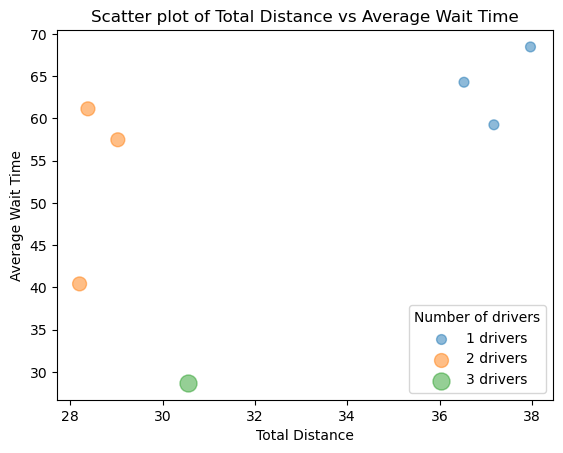

In [2830]:
# Separate the data into lists
number_drivers = [x[0] for x in scatter_list]
total_distance = [x[1] for x in scatter_list]
avg_wait_time = [x[2] for x in scatter_list]

# Create a scatter plot
for drivers in set(number_drivers):
    mask = [x == drivers for x in number_drivers]
    plt.scatter([total_distance[i] for i in range(len(mask)) if mask[i]],
                [avg_wait_time[i] for i in range(len(mask)) if mask[i]],
                s=[drivers * 50 for i in range(len(mask)) if mask[i]],
                label=f'{drivers} drivers', alpha=0.5)

# Set axis labels and title
plt.xlabel('Total Distance')
plt.ylabel('Average Wait Time')
plt.title('Scatter plot of Total Distance vs Average Wait Time')

# Add a legend
plt.legend(title='Number of drivers')

# Show the plot
plt.show()

# Part IV

## part3_small.csv

## Load Data

In [2831]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_orders = pd.read_csv(file_path + 'part3_small.csv')
df_drivers = pd.read_csv(file_path + 'part3_drivers.csv')
df_regions = pd.read_csv(file_path + 'regions.csv')

In [2832]:
df_distances.head()

origin  \
0  Scarborough (Malvern / Rouge River)   
1  Scarborough (Malvern / Rouge River)   
2  Scarborough (Malvern / Rouge River)   
3  Scarborough (Malvern / Rouge River)   
4  Scarborough (Malvern / Rouge River)   

                                         destination  distance  
0  Scarborough (Rouge Hill / Port Union / Highlan...  3.931478  
1  Scarborough (Guildwood / Morningside / Ellesmere)  4.864191  
2                               Scarborough (Woburn)  4.778347  
3                            Scarborough (Cedarbrae)  6.009861  
4                             Scarborough (Eglinton)  7.876162

In [2833]:
df_orders

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM  
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM  
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM  
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM  
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM

In [2834]:
df_drivers

start region  velocity
0  Downtown Toronto (Richmond / Adelaide / King)        40
1              Downtown Toronto (St. James Park)        35
2        Downtown Toronto (Church and Wellesley)        32

In [2835]:
df_regions.head()

name province code  latitude  \
0                Scarborough (Malvern / Rouge River)  Ontario  M1B   43.8113   
1  Scarborough (Rouge Hill / Port Union / Highlan...  Ontario  M1C   43.7878   
2  Scarborough (Guildwood / Morningside / Ellesmere)  Ontario  M1E   43.7678   
3                               Scarborough (Woburn)  Ontario  M1G   43.7712   
4                            Scarborough (Cedarbrae)  Ontario  M1H   43.7686   

   longitude  
0   -79.1930  
1   -79.1564  
2   -79.1866  
3   -79.2144  
4   -79.2389

## Data Preparation

In [2836]:
# Route variables
W = 120
df = df_orders.copy()

In [2837]:
df_merged = df.merge(df_regions, left_on='customer', right_on='name')
df_merged.head()

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  \
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM   
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM   
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM   
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM   
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   

                                                name province code  latitude  \
0  North York (Armour Heights / Wilson Heights / ...  Ontario  M3H   43.7535   
1  West Toronto (Brockton / Parkdale Village / Ex...  Ontario  M6K   43.6383   
2                          York (Fairbank / Oakwood)  Ontario  M6E   43.6889   
3                         East Toronto (The Beaches)  Ontario  M4E   43.6784   
4              Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   

   longitude  
0   -79.4472  
1   -79.4301  
2   -79.4507  
3   -79.2941  
4   -79.3860

In [2838]:
df_drivers = df_drivers.merge(df_regions, left_on='start region', right_on='name')
df_drivers.head()

start region  velocity  \
0  Downtown Toronto (Richmond / Adelaide / King)        40   
1              Downtown Toronto (St. James Park)        35   
2        Downtown Toronto (Church and Wellesley)        32   

                                            name province code  latitude  \
0  Downtown Toronto (Richmond / Adelaide / King)  Ontario  M5H   43.6496   
1              Downtown Toronto (St. James Park)  Ontario  M5C   43.6513   
2        Downtown Toronto (Church and Wellesley)  Ontario  M4Y   43.6656   

   longitude  
0   -79.3833  
1   -79.3756  
2   -79.3830

In [2839]:
coordinates = df_merged[['latitude', 'longitude']]
coordinates

latitude  longitude
0   43.7535   -79.4472
1   43.6383   -79.4301
2   43.6889   -79.4507
3   43.6784   -79.2941
4   43.6564   -79.3860

In [2840]:
df_cluster_centers = df_drivers[['latitude', 'longitude']]
df_cluster_centers

latitude  longitude
0   43.6496   -79.3833
1   43.6513   -79.3756
2   43.6656   -79.3830

In [2841]:
# Initialize KMeans with predefined cluster centers
kmeans = KMeans(n_clusters=len(df_cluster_centers), init=df_cluster_centers.values, n_init=1)

# Fit the model and predict cluster labels
df_merged['cluster'] = kmeans.fit_predict(coordinates)
df_merged

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  \
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM   
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM   
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM   
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM   
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   

                                                name province code  latitude  \
0  North York (Armour Heights / Wilson Heights / ...  Ontario  M3H   43.7535   
1  West Toronto (Brockton / Parkdale Village / Ex...  Ontario  M6K   43.6383   
2                          York (Fairbank / Oakwood)  Ontario  M6E   43.6889   
3                         East Toronto (The Beaches)  Ontario  M4E   43.6784   
4              Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   

   longitude  cluster  
0   -79.4472        2  
1   -79.4301        0  
2   -79.4507        2  
3   -79.2941        1  
4   -79.3860        0

In [2842]:
cluster_to_driver = {i: df_drivers.index[i] for i in range(len(df_cluster_centers))}

# Add a 'driver' column to the df_merged dataframe
df_merged['driver'] = df_merged['cluster'].map(cluster_to_driver)

In [2843]:
df_merged

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  \
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM   
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM   
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM   
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM   
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   

                                                name province code  latitude  \
0  North York (Armour Heights / Wilson Heights / ...  Ontario  M3H   43.7535   
1  West Toronto (Brockton / Parkdale Village / Ex...  Ontario  M6K   43.6383   
2                          York (Fairbank / Oakwood)  Ontario  M6E   43.6889   
3                         East Toronto (The Beaches)  Ontario  M4E   43.6784   
4              Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   

   longitude  cluster  driver  
0   -79.4472        2       2  
1   -79.4301        0       0  
2   -79.4507        2       2  
3   -79.2941        1       1  
4   -79.3860        0       0

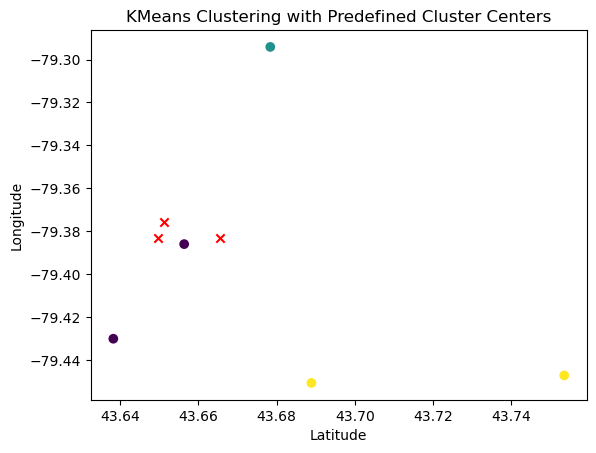

In [2844]:
# Optional: Visualize the results
plt.scatter(df_merged['latitude'], df_merged['longitude'], c=df_merged['cluster'], cmap='viridis')
plt.scatter(df_cluster_centers['latitude'], df_cluster_centers['longitude'], c='red', marker='x')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('KMeans Clustering with Predefined Cluster Centers')
plt.show()

In [2845]:
def one_driver_within_W_P4(W, starting_location, velocity, df, df_distances):
    
    order_quantity = len(df)
    
    # Get start and end locations
    start_locations = list(df['restaurant'].unique()) + list(df['customer'].unique())
    end_locations = start_locations.copy()

    start_locations = list(dict.fromkeys(start_locations))
    end_locations = list(dict.fromkeys(end_locations))

    if starting_location in start_locations:
        start_locations.remove(starting_location)
        start_locations.append(starting_location)
    else:
        start_locations.append(starting_location)   
        
    order_locations = list(df['restaurant']) + list(df['customer'])
    
    # Calculate the number of stops 
    num_steps = np.arange(1, len(end_locations)+1).tolist()
    
    # Get unique Restraurants and Customers
    restaurants = df['restaurant'].unique().tolist()
    customers = df['customer'].unique().tolist()

    order_df = pd.DataFrame({'Restaurant':[], 'Customer':[]})

    for index, row in df.iterrows():
        order_df.loc[index, 'Restaurant'] = row["restaurant"]
        order_df.loc[index, 'Customer'] = row["customer"]
    
    travel_df = pd.DataFrame({'Start':[], 'End': [], 'Distance': [], 'Time': []})

    for i in start_locations:
        for j in end_locations: 
            if i == j:
                new_row_data = {'Start': i, 'End': j, 'Distance': 0, 'Time': 0}
                new_row = pd.DataFrame(new_row_data, index=[0])
                travel_df = pd.concat([travel_df, new_row], ignore_index=True)
            else:
                d_temp = float(df_distances[(df_distances['origin'] == i) & 
                                                              (df_distances['destination'] == j)]['distance'])
                t_temp = d_temp/velocity * 60
                new_row_data = {'Start': i, 'End': j, 'Distance': d_temp, 'Time': t_temp}
                new_row = pd.DataFrame(new_row_data, index=[0])
                travel_df = pd.concat([travel_df, new_row], ignore_index=True)

    df['estimated availability'] = pd.to_datetime(df['estimated availability'])
    df['Converted Availability'] = (df['estimated availability'] - df['estimated availability'].min()).dt.total_seconds() / 60                
                
    ###################

    model = LpProblem(name = 'Part2_Model', sense = LpMinimize)

    xVar = LpVariable.dict('x', (start_locations, end_locations, num_steps), cat = LpBinary)
    # zVar = LpVariable.dict('z', num_steps, lowBound = 0.0, cat = LpContinuous)
    dVar = LpVariable.dict('d', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
    aVar = LpVariable.dict('a', [0] + num_steps, lowBound = -9999.0, cat = LpContinuous)
    wVar = LpVariable.dict('w', (start_locations, num_steps), lowBound = 0.0, cat = LpContinuous)
#     vVar = LpVariable.dict('w', (start_locations, end_locations), lowBound = 0.0, cat = LpContinuous)

    obj = lpSum([travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Distance'].iloc[0] * xVar[(i,j,t)] \
                 for i in start_locations for j in end_locations for t in num_steps])
    model += obj

    model += dVar[(0)] <= 0

    def travel_time_lookup(i, j, travel_df):
        return travel_df[(travel_df['Start']==i) & (travel_df['End']==j)]['Time'].iloc[0]

    # Step time calculation
    for t in num_steps:
        model += aVar[(t)] == dVar[(t-1)] + lpSum([travel_time_lookup(i, j, travel_df) * xVar[(i,j,t)] \
                                                   for i in start_locations for j in restaurants]) + \
                              lpSum([(travel_time_lookup(i, j, travel_df) + 5) * xVar[(i,j,t)] \
                                     for i in start_locations for j in customers])
        model += aVar[(t)] <= dVar[(t)]

    # Driver leaves after the food is ready
    for t in num_steps:
        for i in start_locations:
            for j in restaurants:
                model += dVar[(t)] >= df[df['restaurant'] == j]['Converted Availability'].iloc[0] * xVar[(i,j,t)]

    # Visit restaurant before customer
    for t in num_steps: 
        for j in end_locations: 
            if j in customers: 
                model += pulp.lpSum( [xVar[i,j,t] for i in start_locations]) <= pulp.lpSum([xVar[i, restaurant_customer_match(j, order_df),t_] \
                                                                                            for i in start_locations \
                                                                                            for t_ in num_steps[:t]])

    for idx, row in df.iterrows():
        rst, cus, time = row['restaurant'], row['customer'], row['Converted Availability']
        for t in num_steps:
            model += wVar[(cus, t)] <= 10000000 * lpSum(xVar[(i, cus, t)] for i in start_locations if i != cus)

            model += wVar[(cus, t)] <= aVar[t] - time + 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))
            model += wVar[(cus, t)] >= aVar[t] - time - 10000000 * (1 - lpSum(xVar[(i, cus, t)] for i in start_locations if i !=cus))

    model += W >= lpSum(wVar[(c,t)] for c in customers for t in num_steps)/len(df)

    # Every location receives order once
    for j in end_locations: 
        model += lpSum([xVar[(i,j,t)] for i in start_locations for t in num_steps]) == 1

    # Convervation of flow
    for t in num_steps[:-1]:
        for j in end_locations:
            model += (lpSum([xVar[(i,j,t)] for i in start_locations]) == lpSum([xVar[(j,k,t+1)] for k in end_locations]))

    # First node has an outflow of 1, others 0
    model += lpSum([xVar[(start_locations[-1],j,1)] for j in restaurants]) == 1

    for i in start_locations[:-1]:
        model += lpSum([xVar[(i,j,1)] for j in end_locations]) == 0

    # Solve the model
    model.solve()
    print("Status:", LpStatus[model.status])
    model_status = LpStatus[model.status]
    
    if LpStatus[model.status] == 'Optimal':
    
        total_distance = pulp.value(model.objective)
        print("Total Distance: " , total_distance)

        total_wait_time = sum([wVar[(j,t)].varValue for j in end_locations for t in num_steps if wVar[(j,t)].varValue != None])
        print('Total wait: ' + str(total_wait_time))
        
        avg_wait_time = total_wait_time/len(customers)
        print('Average wait: ' + str(avg_wait_time))
        
    else:
        total_distance = 0
        total_wait_time = 0
        avg_wait_time = 0
        
    
    path_summary_df = pd.DataFrame({'Step Number':[], 'Departure Time (min)':[], 'Leaving': [], 
                                    'Arriving': [], 'Wait Time': []})

    for t in num_steps: 
#         print('Stop number: ' + str(t))
        path_summary_df.loc[t, 'Step Number'] = t
#         print('Travel time(mins): ' + str(dVar[t].varValue))
        path_summary_df.loc[t, 'Departure Time (min)'] = dVar[t].varValue

        for i in start_locations: 
            for j in end_locations: 

                if xVar[(i,j,t)].varValue > 0.0:
                    path_summary_df.loc[t, 'Leaving'] = i
#                     print('\tLeft from location: ' + str(i))
                    path_summary_df.loc[t, 'Arriving'] = j
#                     print('\tArrived at location: ' + str(j))
                    path_summary_df.loc[t, 'Wait Time'] = wVar[(j,t)].varValue
#                     print('\tWait time: ' + str(wVar[(j,t)].varValue))
                    
    
    print('=======================================')
        
    display(path_summary_df)

    return {'order_quantity': order_quantity,
           'model_status': model_status,
           'total_distance': total_distance,
           'total_wait_time': total_wait_time,
            'avg_wait_time': avg_wait_time
           }, total_distance, total_wait_time, order_quantity

In [2846]:
# Group the dataframe by the 'cluster' column
grouped_df = df_merged.groupby('cluster')

# Create a list of dataframes for each cluster, resetting the index
dfs_by_cluster = [group.reset_index(drop=True) for _, group in grouped_df]

r_list = []
total_distance_list = []
total_wait_list = []
number_orders_list = []

# Print the dataframes in the list
for i, cluster_df in enumerate(dfs_by_cluster):
    driver = cluster_df.loc[0, 'driver']
    
    start_region = df_drivers.loc[driver, 'start region']
    velocity = df_drivers.loc[driver, 'velocity']
    cluster_num = cluster_df.iloc[0,-1]
    
    print("Cluster: " + str(cluster_num) + "\n" + "###############################")
    
    r_dict, total_distance, total_wait, number_orders = one_driver_within_W_P4(W, start_region, velocity, 
                                                                       cluster_df.copy(), df_distances.copy())
    r_list.append(r_dict)
    total_distance_list.append(total_distance)
    total_wait_list.append(total_wait)
    number_orders_list.append(number_orders)
    

Cluster: 0
###############################
Status: Optimal
Total Distance:  8.75116131301983
Total wait: 16.6108851
Average wait: 8.30544255


Step Number  Departure Time (min)  \
1          1.0              0.000000   
2          2.0              6.474741   
3          3.0             25.000000   
4          4.0             35.136144   

                                             Leaving  \
1      Downtown Toronto (Richmond / Adelaide / King)   
2  Downtown Toronto (Kensington Market / Chinatow...   
3              Downtown Toronto (Central Bay Street)   
4                        Downtown Toronto (Christie)   

                                            Arriving  Wait Time  
1  Downtown Toronto (Kensington Market / Chinatow...        NaN  
2              Downtown Toronto (Central Bay Street)   6.474741  
3                        Downtown Toronto (Christie)        NaN  
4  West Toronto (Brockton / Parkdale Village / Ex...  10.136144

Cluster: 1
###############################
Status: Optimal
Total Distance:  7.215062444138449
Total wait: 17.368678
Average wait: 17.368678


Step Number  Departure Time (min)                            Leaving  \
1          1.0              0.000000  Downtown Toronto (St. James Park)   
2          2.0             17.368678  Downtown Toronto (St. James Park)   

                            Arriving  Wait Time  
1  Downtown Toronto (St. James Park)        NaN  
2         East Toronto (The Beaches)  17.368678

Cluster: 2
###############################
Status: Optimal
Total Distance:  15.157594055213657
Total wait: 114.583441
Average wait: 57.2917205


Step Number  Departure Time (min)                                  Leaving  \
1          1.0             60.000000  Downtown Toronto (Church and Wellesley)   
2          2.0             61.173387               Downtown Toronto (Ryerson)   
3          3.0             78.052308    Downtown Toronto (Central Bay Street)   
4          4.0             96.531133                York (Fairbank / Oakwood)   

                                            Arriving  Wait Time  
1                         Downtown Toronto (Ryerson)        NaN  
2              Downtown Toronto (Central Bay Street)        NaN  
3                          York (Fairbank / Oakwood)  18.052308  
4  North York (Armour Heights / Wilson Heights / ...  96.531133

In [2847]:
final_total_distance = sum(total_distance_list)
final_average_wait = sum(total_wait_list)/sum(number_orders_list)

print("Total distance: " + str(final_total_distance))
print("Average wait time: " + str(final_average_wait))

Total distance: 31.123817812371936
Average wait time: 29.71260082


## part4_large.csv with part4_drivers.csv

## Load Data

In [2848]:
df_distances = pd.read_csv(file_path + 'distances.csv')

df_orders = pd.read_csv(file_path + 'part4_large.csv')
df_drivers = pd.read_csv(file_path + 'part4_drivers.csv')
df_regions = pd.read_csv(file_path + 'regions.csv')

In [2849]:
df_distances.head()

origin  \
0  Scarborough (Malvern / Rouge River)   
1  Scarborough (Malvern / Rouge River)   
2  Scarborough (Malvern / Rouge River)   
3  Scarborough (Malvern / Rouge River)   
4  Scarborough (Malvern / Rouge River)   

                                         destination  distance  
0  Scarborough (Rouge Hill / Port Union / Highlan...  3.931478  
1  Scarborough (Guildwood / Morningside / Ellesmere)  4.864191  
2                               Scarborough (Woburn)  4.778347  
3                            Scarborough (Cedarbrae)  6.009861  
4                             Scarborough (Eglinton)  7.876162

In [2850]:
df_orders.head()

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM  
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM  
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM  
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM  
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM

In [2851]:
df_drivers.head()

start region  velocity
0  Downtown Toronto (Richmond / Adelaide / King)        20
1              Downtown Toronto (St. James Park)        20
2        Downtown Toronto (Church and Wellesley)        20
3                    Downtown Toronto (Christie)        20
4        Downtown Toronto (Church and Wellesley)        20

In [2852]:
df_regions.head()

name province code  latitude  \
0                Scarborough (Malvern / Rouge River)  Ontario  M1B   43.8113   
1  Scarborough (Rouge Hill / Port Union / Highlan...  Ontario  M1C   43.7878   
2  Scarborough (Guildwood / Morningside / Ellesmere)  Ontario  M1E   43.7678   
3                               Scarborough (Woburn)  Ontario  M1G   43.7712   
4                            Scarborough (Cedarbrae)  Ontario  M1H   43.7686   

   longitude  
0   -79.1930  
1   -79.1564  
2   -79.1866  
3   -79.2144  
4   -79.2389

## Data Preparation

In [2853]:
# Route variables
W = 120
df = df_orders.copy()

In [2854]:
df_merged = df.merge(df_regions, left_on='customer', right_on='name')
df_merged.head()

restaurant  \
0              Downtown Toronto (Central Bay Street)   
1                        Downtown Toronto (Christie)   
2                         Downtown Toronto (Ryerson)   
3                  Downtown Toronto (St. James Park)   
4  Downtown Toronto (Kensington Market / Chinatow...   

                                            customer estimated availability  \
0  North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM   
1  West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM   
2                          York (Fairbank / Oakwood)     2022-04-02 6:17 PM   
3                         East Toronto (The Beaches)     2022-04-02 5:53 PM   
4              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   

                                                name province code  latitude  \
0  North York (Armour Heights / Wilson Heights / ...  Ontario  M3H   43.7535   
1  West Toronto (Brockton / Parkdale Village / Ex...  Ontario  M6K   43.6383   
2                          York (Fairbank / Oakwood)  Ontario  M6E   43.6889   
3                         East Toronto (The Beaches)  Ontario  M4E   43.6784   
4              Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   

   longitude  
0   -79.4472  
1   -79.4301  
2   -79.4507  
3   -79.2941  
4   -79.3860

In [2855]:
df_drivers = df_drivers.merge(df_regions, left_on='start region', right_on='name')
df_drivers.head()

start region  velocity  \
0  Downtown Toronto (Richmond / Adelaide / King)        20   
1              Downtown Toronto (St. James Park)        20   
2        Downtown Toronto (Church and Wellesley)        20   
3        Downtown Toronto (Church and Wellesley)        20   
4                    Downtown Toronto (Christie)        20   

                                            name province code  latitude  \
0  Downtown Toronto (Richmond / Adelaide / King)  Ontario  M5H   43.6496   
1              Downtown Toronto (St. James Park)  Ontario  M5C   43.6513   
2        Downtown Toronto (Church and Wellesley)  Ontario  M4Y   43.6656   
3        Downtown Toronto (Church and Wellesley)  Ontario  M4Y   43.6656   
4                    Downtown Toronto (Christie)  Ontario  M6G   43.6683   

   longitude  
0   -79.3833  
1   -79.3756  
2   -79.3830  
3   -79.3830  
4   -79.4205

In [2856]:
coordinates = df_merged[['latitude', 'longitude']]
coordinates

latitude  longitude
0    43.7535   -79.4472
1    43.6383   -79.4301
2    43.6889   -79.4507
3    43.6784   -79.2941
4    43.6564   -79.3860
5    43.6564   -79.3860
6    43.6404   -79.3995
7    43.6469   -79.3823
8    43.6748   -79.4839
9    43.6861   -79.4025
10   43.6803   -79.3538
11   43.7063   -79.3094
12   43.7598   -79.5565
13   43.6736   -79.4035
14   43.6693   -79.3155

In [2857]:
df_cluster_centers = df_drivers[['latitude', 'longitude']]
df_cluster_centers

latitude  longitude
0   43.6496   -79.3833
1   43.6513   -79.3756
2   43.6656   -79.3830
3   43.6656   -79.3830
4   43.6683   -79.4205
5   43.6437   -79.3787
6   43.6404   -79.3995
7   43.6827   -79.3730
8   43.6629   -79.3987
9   43.6572   -79.3783

In [2858]:
# Initialize KMeans with predefined cluster centers
kmeans = KMeans(n_clusters=len(df_cluster_centers), init=df_cluster_centers.values, n_init=1)

# Fit the model and predict cluster labels
df_merged['cluster'] = kmeans.fit_predict(coordinates)
df_merged

restaurant  \
0               Downtown Toronto (Central Bay Street)   
1                         Downtown Toronto (Christie)   
2                          Downtown Toronto (Ryerson)   
3                   Downtown Toronto (St. James Park)   
4   Downtown Toronto (Kensington Market / Chinatow...   
5                         Downtown Toronto (Rosedale)   
6                         Downtown Toronto (Rosedale)   
7    Downtown Toronto (Regent Park / Port of Toronto)   
8     Downtown Toronto (St. James Town / Cabbagetown)   
9                 Downtown Toronto (Underground city)   
10            Downtown Toronto (Church and Wellesley)   
11      Downtown Toronto (Richmond / Adelaide / King)   
12  Downtown Toronto (University of Toronto / Harb...   
13                  Downtown Toronto (St. James Park)   
14                  Downtown Toronto (St. James Park)   

                                             customer estimated availability  \
0   North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM   
1   West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM   
2                           York (Fairbank / Oakwood)     2022-04-02 6:17 PM   
3                          East Toronto (The Beaches)     2022-04-02 5:53 PM   
4               Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   
5               Downtown Toronto (Central Bay Street)     2022-04-02 5:00 PM   
6   Downtown Toronto (CN Tower / King and Spadina ...     2022-04-02 7:35 PM   
7   Downtown Toronto (Toronto Dominion Centre / De...     2022-04-02 6:21 PM   
8               York (Runnymede / The Junction North)     2022-04-02 5:10 PM   
9   Central Toronto (Summerhill West / Rathnelly /...     2022-04-02 5:21 PM   
10       East Toronto (The Danforth West / Riverdale)     2022-04-02 7:21 PM   
11       East York (Parkview Hill / Woodbine Gardens)     2022-04-02 7:15 PM   
12                         North York (Humber Summit)     2022-04-02 6:49 PM   
13  Central Toronto (The Annex / North Midtown / Y...     2022-04-02 5:56 PM   
14     East Toronto (India Bazaar / The Beaches West)     2022-04-02 7:24 PM   

                                                 name province code  latitude  \
0   North York (Armour Heights / Wilson Heights / ...  Ontario  M3H   43.7535   
1   West Toronto (Brockton / Parkdale Village / Ex...  Ontario  M6K   43.6383   
2                           York (Fairbank / Oakwood)  Ontario  M6E   43.6889   
3                          East Toronto (The Beaches)  Ontario  M4E   43.6784   
4               Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   
5               Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   
6   Downtown Toronto (CN Tower / King and Spadina ...  Ontario  M5V   43.6404   
7   Downtown Toronto (Toronto Dominion Centre / De...  Ontario  M5K   43.6469   
8               York (Runnymede / The Junction North)  Ontario  M6N   43.6748   
9   Central Toronto (Summerhill West / Rathnelly /...  Ontario  M4V   43.6861   
10       East Toronto (The Danforth West / Riverdale)  Ontario  M4K   43.6803   
11       East York (Parkview Hill / Woodbine Gardens)  Ontario  M4B   43.7063   
12                         North York (Humber Summit)  Ontario  M9L   43.7598   
13  Central Toronto (The Annex / North Midtown / Y...  Ontario  M5R   43.6736   
14     East Toronto (India Bazaar / The Beaches West)  Ontario  M4L   43.6693   

    longitude  cluster  
0    -79.4472        2  
1    -79.4301        6  
2    -79.4507        4  
3    -79.2941        3  
4    -79.3860        0  
5    -79.3860        0  
6    -79.3995        6  
7    -79.3823        0  
8    -79.4839        9  
9    -79.4025        8  
10   -79.3538        7  
11   -79.3094        5  
12   -79.5565        1  
13   -79.4035        8  
14   -79.3155        7

In [2859]:
cluster_to_driver = {i: df_drivers.index[i] for i in range(len(df_cluster_centers))}

# Add a 'driver' column to the df_merged dataframe
df_merged['driver'] = df_merged['cluster'].map(cluster_to_driver)

In [2860]:
df_merged

restaurant  \
0               Downtown Toronto (Central Bay Street)   
1                         Downtown Toronto (Christie)   
2                          Downtown Toronto (Ryerson)   
3                   Downtown Toronto (St. James Park)   
4   Downtown Toronto (Kensington Market / Chinatow...   
5                         Downtown Toronto (Rosedale)   
6                         Downtown Toronto (Rosedale)   
7    Downtown Toronto (Regent Park / Port of Toronto)   
8     Downtown Toronto (St. James Town / Cabbagetown)   
9                 Downtown Toronto (Underground city)   
10            Downtown Toronto (Church and Wellesley)   
11      Downtown Toronto (Richmond / Adelaide / King)   
12  Downtown Toronto (University of Toronto / Harb...   
13                  Downtown Toronto (St. James Park)   
14                  Downtown Toronto (St. James Park)   

                                             customer estimated availability  \
0   North York (Armour Heights / Wilson Heights / ...     2022-04-02 5:17 PM   
1   West Toronto (Brockton / Parkdale Village / Ex...     2022-04-02 5:49 PM   
2                           York (Fairbank / Oakwood)     2022-04-02 6:17 PM   
3                          East Toronto (The Beaches)     2022-04-02 5:53 PM   
4               Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   
5               Downtown Toronto (Central Bay Street)     2022-04-02 5:00 PM   
6   Downtown Toronto (CN Tower / King and Spadina ...     2022-04-02 7:35 PM   
7   Downtown Toronto (Toronto Dominion Centre / De...     2022-04-02 6:21 PM   
8               York (Runnymede / The Junction North)     2022-04-02 5:10 PM   
9   Central Toronto (Summerhill West / Rathnelly /...     2022-04-02 5:21 PM   
10       East Toronto (The Danforth West / Riverdale)     2022-04-02 7:21 PM   
11       East York (Parkview Hill / Woodbine Gardens)     2022-04-02 7:15 PM   
12                         North York (Humber Summit)     2022-04-02 6:49 PM   
13  Central Toronto (The Annex / North Midtown / Y...     2022-04-02 5:56 PM   
14     East Toronto (India Bazaar / The Beaches West)     2022-04-02 7:24 PM   

                                                 name province code  latitude  \
0   North York (Armour Heights / Wilson Heights / ...  Ontario  M3H   43.7535   
1   West Toronto (Brockton / Parkdale Village / Ex...  Ontario  M6K   43.6383   
2                           York (Fairbank / Oakwood)  Ontario  M6E   43.6889   
3                          East Toronto (The Beaches)  Ontario  M4E   43.6784   
4               Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   
5               Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   
6   Downtown Toronto (CN Tower / King and Spadina ...  Ontario  M5V   43.6404   
7   Downtown Toronto (Toronto Dominion Centre / De...  Ontario  M5K   43.6469   
8               York (Runnymede / The Junction North)  Ontario  M6N   43.6748   
9   Central Toronto (Summerhill West / Rathnelly /...  Ontario  M4V   43.6861   
10       East Toronto (The Danforth West / Riverdale)  Ontario  M4K   43.6803   
11       East York (Parkview Hill / Woodbine Gardens)  Ontario  M4B   43.7063   
12                         North York (Humber Summit)  Ontario  M9L   43.7598   
13  Central Toronto (The Annex / North Midtown / Y...  Ontario  M5R   43.6736   
14     East Toronto (India Bazaar / The Beaches West)  Ontario  M4L   43.6693   

    longitude  cluster  driver  
0    -79.4472        2       2  
1    -79.4301        6       6  
2    -79.4507        4       4  
3    -79.2941        3       3  
4    -79.3860        0       0  
5    -79.3860        0       0  
6    -79.3995        6       6  
7    -79.3823        0       0  
8    -79.4839        9       9  
9    -79.4025        8       8  
10   -79.3538        7       7  
11   -79.3094        5       5  
12   -79.5565        1       1  
13   -79.4035        8       8  
14   -79.3155        7       7

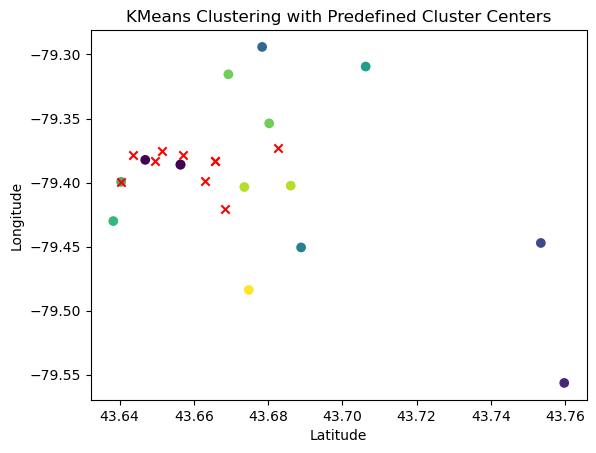

In [2861]:
# Optional: Visualize the results
plt.scatter(df_merged['latitude'], df_merged['longitude'], c=df_merged['cluster'], cmap='viridis')
plt.scatter(df_cluster_centers['latitude'], df_cluster_centers['longitude'], c='red', marker='x')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('KMeans Clustering with Predefined Cluster Centers')
plt.show()

In [2862]:
# Group the dataframe by the 'cluster' column
grouped_df = df_merged.groupby('cluster')

# Create a list of dataframes for each cluster, resetting the index
dfs_by_cluster = [group.reset_index(drop=True) for _, group in grouped_df]

r_list = []
total_distance_list = []
total_wait_list = []
number_orders_list = []

# Print the dataframes in the list
for i, cluster_df in enumerate(dfs_by_cluster):
    driver = cluster_df.loc[0, 'driver']
    
    start_region = df_drivers.loc[driver, 'start region']
    velocity = df_drivers.loc[driver, 'velocity']
    cluster_num = cluster_df.iloc[0,-1]
    
    print("Cluster: " + str(cluster_num) + "\n" + "###############################")
    
    r_dict, total_distance, total_wait, number_orders = one_driver_within_W_P4(W, start_region, velocity, 
                                                                       cluster_df.copy(), df_distances.copy())
    r_list.append(r_dict)
    total_distance_list.append(total_distance)
    total_wait_list.append(total_wait)
    number_orders_list.append(number_orders)
    

Cluster: 0
###############################
Status: Infeasible


Step Number  Departure Time (min)  \
1          1.0             16.200000   
2          2.0             20.548833   
3          3.0             23.048833   
4          4.0             25.548833   
5          5.0             28.048833   

                                             Leaving  \
1      Downtown Toronto (Richmond / Adelaide / King)   
2   Downtown Toronto (Regent Park / Port of Toronto)   
3  Downtown Toronto (Toronto Dominion Centre / De...   
4  Downtown Toronto (Toronto Dominion Centre / De...   
5  Downtown Toronto (Toronto Dominion Centre / De...   

                                            Arriving  Wait Time  
1   Downtown Toronto (Regent Park / Port of Toronto)        NaN  
2   Downtown Toronto (Regent Park / Port of Toronto)        NaN  
3  Downtown Toronto (Toronto Dominion Centre / De...        0.0  
4  Downtown Toronto (Toronto Dominion Centre / De...        0.0  
5  Downtown Toronto (Toronto Dominion Centre / De...        0.0

Cluster: 1
###############################
Status: Optimal
Total Distance:  18.904231533909154
Total wait: 54.926328
Average wait: 54.926328


Step Number  Departure Time (min)  \
1          1.0              0.000000   
2          2.0             54.926328   

                                             Leaving  \
1                  Downtown Toronto (St. James Park)   
2  Downtown Toronto (University of Toronto / Harb...   

                                            Arriving  Wait Time  
1  Downtown Toronto (University of Toronto / Harb...        NaN  
2                         North York (Humber Summit)  54.926328

Cluster: 2
###############################
Status: Optimal
Total Distance:  12.916041275917584
Total wait: 40.594901
Average wait: 40.594901


Step Number  Departure Time (min)                                  Leaving  \
1          1.0              0.000000  Downtown Toronto (Church and Wellesley)   
2          2.0             40.594901    Downtown Toronto (Central Bay Street)   

                                            Arriving  Wait Time  
1              Downtown Toronto (Central Bay Street)        NaN  
2  North York (Armour Heights / Wilson Heights / ...  40.594901

Cluster: 3
###############################
Status: Optimal
Total Distance:  8.91293415432978
Total wait: 26.645187
Average wait: 26.645187


Step Number  Departure Time (min)                                  Leaving  \
1          1.0              0.000000  Downtown Toronto (Church and Wellesley)   
2          2.0             26.645187        Downtown Toronto (St. James Park)   

                            Arriving  Wait Time  
1  Downtown Toronto (St. James Park)        NaN  
2         East Toronto (The Beaches)  26.645187

Cluster: 4
###############################
Status: Optimal
Total Distance:  10.418674972983524
Total wait: 25.420003999999988
Average wait: 25.420003999999988


Step Number  Departure Time (min)                      Leaving  \
1          1.0              0.000000  Downtown Toronto (Christie)   
2          2.0             25.420004   Downtown Toronto (Ryerson)   

                     Arriving  Wait Time  
1  Downtown Toronto (Ryerson)        NaN  
2   York (Fairbank / Oakwood)  25.420004

Cluster: 5
###############################
Status: Optimal
Total Distance:  9.417530972137655
Total wait: 30.99282399999998
Average wait: 30.99282399999998


Step Number  Departure Time (min)  \
1          1.0              0.000000   
2          2.0             30.992824   

                                             Leaving  \
1  Downtown Toronto Stn A PO Boxes 25 The Esplana...   
2      Downtown Toronto (Richmond / Adelaide / King)   

                                        Arriving  Wait Time  
1  Downtown Toronto (Richmond / Adelaide / King)        NaN  
2   East York (Parkview Hill / Woodbine Gardens)  30.992824

Cluster: 6
###############################
Status: Optimal
Total Distance:  15.203751534664187
Total wait: 173.817663
Average wait: 86.9088315


Step Number  Departure Time (min)  \
1          1.0             106.00000   
2          2.0             118.42632   
3          3.0             133.69861   
4          4.0             146.11905   

                                             Leaving  \
1  Downtown Toronto (CN Tower / King and Spadina ...   
2                        Downtown Toronto (Rosedale)   
3                        Downtown Toronto (Christie)   
4  West Toronto (Brockton / Parkdale Village / Ex...   

                                            Arriving   Wait Time  
1                        Downtown Toronto (Rosedale)         NaN  
2                        Downtown Toronto (Christie)         NaN  
3  West Toronto (Brockton / Parkdale Village / Ex...  133.698610  
4  Downtown Toronto (CN Tower / King and Spadina ...   40.119053

Cluster: 7
###############################
Status: Optimal
Total Distance:  10.74719905762331
Total wait: 54.153389000000004
Average wait: 27.076694500000002


Step Number  Departure Time (min)  \
1          1.0              0.000000   
2          2.0              5.093615   
3          3.0             21.105377   
4          4.0             36.048012   

                                        Leaving  \
1                   Downtown Toronto (Rosedale)   
2       Downtown Toronto (Church and Wellesley)   
3             Downtown Toronto (St. James Park)   
4  East Toronto (The Danforth West / Riverdale)   

                                         Arriving  Wait Time  
1         Downtown Toronto (Church and Wellesley)        NaN  
2               Downtown Toronto (St. James Park)        NaN  
3    East Toronto (The Danforth West / Riverdale)  21.105377  
4  East Toronto (India Bazaar / The Beaches West)  33.048012

Cluster: 8
###############################
Status: Optimal
Total Distance:  7.339496158731992
Total wait: 74.24365399999999
Average wait: 37.121826999999996


Step Number  Departure Time (min)  \
1          1.0              0.000000   
2          2.0             35.000000   
3          3.0             50.033433   
4          4.0             59.210221   

                                             Leaving  \
1  Downtown Toronto (University of Toronto / Harb...   
2                Downtown Toronto (Underground city)   
3                  Downtown Toronto (St. James Park)   
4  Central Toronto (The Annex / North Midtown / Y...   

                                            Arriving  Wait Time  
1                Downtown Toronto (Underground city)        NaN  
2                  Downtown Toronto (St. James Park)        NaN  
3  Central Toronto (The Annex / North Midtown / Y...  15.033433  
4  Central Toronto (Summerhill West / Rathnelly /...  59.210221

Cluster: 9
###############################
Status: Optimal
Total Distance:  10.733567837526653
Total wait: 32.82982699999998
Average wait: 32.82982699999998


Step Number  Departure Time (min)  \
1          1.0              0.000000   
2          2.0             32.829827   

                                           Leaving  \
1                       Downtown Toronto (Ryerson)   
2  Downtown Toronto (St. James Town / Cabbagetown)   

                                          Arriving  Wait Time  
1  Downtown Toronto (St. James Town / Cabbagetown)        NaN  
2            York (Runnymede / The Junction North)  32.829827

In [2863]:
final_total_distance = sum(total_distance_list)
final_average_wait = sum(total_wait_list)/sum(number_orders_list)

print("Total distance: " + str(final_total_distance))
print("Average wait time: " + str(final_average_wait))

Total distance: 104.59342749782384
Average wait time: 34.241585133333324


In [2864]:
dfs_by_cluster[0]

restaurant  \
0  Downtown Toronto (Kensington Market / Chinatow...   
1                        Downtown Toronto (Rosedale)   
2   Downtown Toronto (Regent Park / Port of Toronto)   

                                            customer estimated availability  \
0              Downtown Toronto (Central Bay Street)     2022-04-02 5:24 PM   
1              Downtown Toronto (Central Bay Street)     2022-04-02 5:00 PM   
2  Downtown Toronto (Toronto Dominion Centre / De...     2022-04-02 6:21 PM   

                                                name province code  latitude  \
0              Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   
1              Downtown Toronto (Central Bay Street)  Ontario  M5G   43.6564   
2  Downtown Toronto (Toronto Dominion Centre / De...  Ontario  M5K   43.6469   

   longitude  cluster  driver  
0   -79.3860        0       0  
1   -79.3860        0       0  
2   -79.3823        0       0